This notebook implements many differents solutions for the PLN PCA model. This is more a test of the  differents methods since we are building ourselves the data, and we know the true parameter Sigma and beta. This is just to check the method. 

In [173]:
%load_ext autoreload

%autoreload 2

device :  cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import math
import time 
from utils import Poisson_reg, sample_PLN
import matplotlib.pyplot as plt

import numpy as np
import torch
import threading
import seaborn as sns
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
from sklearn.linear_model import LinearRegression
torch.set_default_dtype(torch.float64)

In [3]:
#get the device
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

device :  cpu


In [4]:
def ELBO(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    compute the ELBO. We use Sigma in this formula. This has nothing to do with PCA,
    It is only to check for the case p=q. 
    Parametrisation centered in X@beta and Sigma
    '''
    n,p = Y.shape
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp


def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO.  
    '''
    A = O + torch.mm(covariates,beta)+torch.mm(M,C.T)
    SrondS = torch.multiply(S,S)
    first = torch.sum(torch.multiply(Y,A))
    second = torch.sum(-1/2*torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C).T)))
    third = torch.sum(+1/2*torch.log(SrondS))
    fourth = torch.sum(-1/2*(torch.multiply(M,M)+torch.multiply(S,S)))
    return first +second + third + fourth

In [192]:
class fastPLNPCA():
    def __init__(self): 
        '''
        Initialization. We only define some useful stuff. The real initalization is done 
        in the init_data() func. 
        '''
        self.old_loss = 1
        # some lists to store some stats
        self.ELBO_list = list()
        self.running_times = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        
    def init_data(self,data,q): 
        '''
        function to extract the data and initialize the parameters. 
        This function is just here to have a code more compact.
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        torch.manual_seed(0)
        self.Y = data[0].to(device);self.O = data[1].to(device);self.covariates = data[2].to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]
        self.q = q 
        #model parameter 
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1).to(device)
        self.beta = torch.rand((self.d, self.p)).to(device)
        self.beta.requires_grad_(True)
        #variational parameter
        self.M = torch.randn((self.n,self.q)).to(device)
        self.M.requires_grad_(True)
        self.S = torch.randn((self.n,self.q)).to(device)
        self.S.requires_grad_(True)
        
        self.C = torch.clone(C_from_Sigma(self.Sigma,self.q))
        #print('norm sym :', torch.norm())
        self.C.requires_grad_(True)
        self.params = {'S' : self.S,'M': self.M, 'beta' : self.beta, 'Sigma' : self.Sigma, 'C' : self.C}
        
        
    ###################### parametrisation centered in X@\beta, variance CC.T ##############
    
    
    def compute_ELBO(self): 
        '''
        Computes the ELBO with the parameter of the model.
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    def compute_ELBO_PCA(self):
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    def get_Sigma_from_C(self): 
        return torch.mm(self.C,self.C.T)
    
    #def compute_ELBO_PCA(self): 
        #print('diff : ', torch.norm(self.Sigma-self.get_Sigma_from_C()))
        #return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S , self.get_Sigma_from_C() ,self.beta)
    
    def compute_ELBO_C(self): 
        return ELBO_C(self.Y,self.O,self.covariates,self.M,self.S, self.C,self.beta)
    
    def fit(self,data, N_iter, q, loss_choice = 'PCA', tolerance = 0, optimizer = torch.optim.Rprop, lr = 1,verbose = False): 
        self.loss_choice = loss_choice
        self.t0 = time.time()
        #initialize the data
        self.init_data(data,q)
        self.optimizer = optimizer([self.S,self.M,self.C,self.beta], lr = lr)
        stop_condition = False 
        i = 0
        while i < N_iter and stop_condition == False: 
            self.optimizer.zero_grad()
            loss = -self.compute_ELBO_PCA()
            loss.backward()
            self.optimizer.step()
            delta = self.old_loss - loss.item() # precision 
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            self.old_loss = loss.item()

            self.ELBO_list.append(-loss.item())# keep track of the ELBO
            # print some stats if we want to
            if i%10 == 0 and verbose : 
                print('Iteration number: ', i)
                print('-------UPDATE-------')
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                #print('MSE closed form : ', torch.mean((true_Sigma-self.Sigma)**2))
                self.print_MSE()
            i += 1
            #keep track of the time and the MSE
            self.running_times.append(time.time()-self.t0)
            self.MSE_Sigma_list.append(torch.mean((self.get_Sigma()-true_Sigma)**2))
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2))
        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_iter, 'last delta = ', delta)

    
    
    def VEM(self,data, N_iter,N_iter_mod,N_iter_var, q, tolerance = 0, optimizer = torch.optim.Rprop, lr_var = 1,lr_mod = 1, verbose = False): 
        '''
        VEM where we do the VE step and then the M step. 
        '''
        
        self.loss_choice = 'PCA'
        self.t0 = time.time()
        #initialize the data
        self.init_data(data,q)
        self.var_optimizer = optimizer([self.S,self.M], lr = lr_var)
        self.model_optimizer = optimizer([self.C,self.beta], lr = lr_mod)
        stop_condition = False 
        i = 0
        while i < N_iter and stop_condition == False: 
            #print('MSE : ', torch.mean((self.beta-true_beta)**2))
            
            for _ in range(N_iter_mod): 
                self.model_optimizer.zero_grad()
                loss = -self.compute_ELBO_PCA()
                loss.backward()
                self.model_optimizer.step()
                delta = self.old_loss - loss.item() # precision 
                # condition to see if we have reach the tolerance threshold
                if  abs(delta) < 0/(i+1) :
                    stop_condition = True 
                self.old_loss = loss.item()
            for _ in range(N_iter_var): 
                self.var_optimizer.zero_grad()
                loss = -self.compute_ELBO_PCA()
                loss.backward()
                self.var_optimizer.step()
                delta = self.old_loss - loss.item() # precision 
                # condition to see if we have reach the tolerance threshold
                if  abs(delta) < 0/(i+1) :
                    stop_condition = True 
                self.old_loss = loss.item()
                
            #print('Cnorm : ', torch.norm(self.C))
            self.ELBO_list.append(-loss.item())# keep track of the ELBO
            # print some stats if we want to
            if i%10 == 0 and verbose : 
                print('Iteration number: ', i)
                print('-------UPDATE-------')
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                #print('MSE closed form : ', torch.mean((true_Sigma-self.Sigma)**2))
                self.print_MSE()
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)
            #uupdate the parameters with their closed form. 
            #self.beta = self.closed_beta()
            
            self.MSE_Sigma_list.append(torch.mean((self.get_Sigma()-true_Sigma)**2))
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2))
            #self.C = C_from_Sigma(self.Sigma,self.q)
        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_iter, 'last delta = ', delta)

    def closed_Sigma(self):
        '''
        closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
        '''
        n,p = self.M.shape
        MmoinsXB = self.M-torch.mm(self.covariates,self.beta)
        return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0)))
    def closed_beta(self): 
        '''
        closed form for beta with the first parametrisation above
        '''
        ## a améliorer l'inverse ? avec un np.linalg.solve ? 
        return torch.mm(torch.mm(torch.inverse(torch.mm(self.covariates.T,self.covariates)), self.covariates.T),self.M)
    
    def show_Sigma(self): 
        '''
        simple function to show the Sigma of the model.
        It will display it with a heatmap. 
        '''
        sns.heatmap(self.get_Sigma().detach().numpy())
        plt.show()
        
    def print_MSE(self):    
        print('MSE_Sigma :', torch.mean((self.get_Sigma()-true_Sigma)**2))
        print('MSE_beta :', torch.mean((self.beta-true_beta)**2))
    def get_Sigma(self): 
        return self.C@(self.C.T)
    
    def grad_C(self): 
        #print('myC shape : ', self.C.shape)
        SrondS = torch.multiply(self.S,self.S)
        MmoinsXB = self.M-torch.mm(self.covariates,self.beta)
        inv = torch.inverse(torch.mm(self.C,self.C.T))
        first = -self.n*(torch.mm(inv,self.C))
        A = torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
        second = 1/2*inv@(A+A.T)@inv@self.C
        return first + second
    
    def gradPCA_beta(self):
        matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first_term = torch.mm(self.covariates.T,self.Y)
        second_term = -1/2*torch.mm(
                             self.covariates.T,
                             torch.exp(self.O+torch.mm(self.covariates,self.beta)+torch.mm(self.M,matC.T)+1/2*torch.mm(SrondS,CrondC.T))
                             )
        return first_term+second_term
    def gradPCA_M(self):
        matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        first = torch.mm(self.Y,matC)
        second = -1/2*torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),matC)
        third = -self.M
        return first + second+third
    def gradPCA_S(self):
        matC = self.C
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        first = -1/2*torch.multiply(self.S,torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),CrondC))
        second = torch.div(1,self.S)
        third = -self.S
        return first + second +third
    
    def gradPCA_C(self):
        matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first = torch.mm(self.Y.T,self.M) 
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        exp = torch.exp(A + 1/2*torch.mm(SrondS,CrondC.T))
        second = -1/2*torch.mm(exp.T,self.M)-1/2*torch.multiply(matC,torch.mm(exp.T,SrondS))
        return first + second

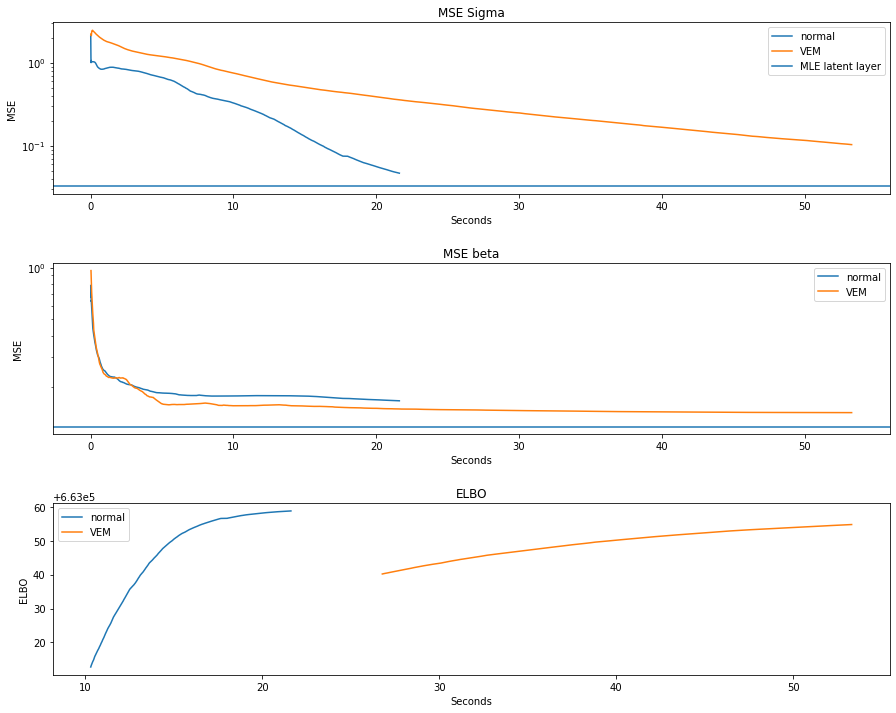

In [198]:
compare_models({'normal': model, 'VEM': model_VEM}, '', percentage_kept = 0.5)

In [122]:
def launch_dimensions(dict_dimensions,N_iter, lr):
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         lr : float. the learning rate of each optimizer.
    '''
    ts = list()
    models = list()
    for name, dim in dict_dimensions.items(): 
        model = fastPLNPCA()
        t = threading.Thread(target =model.fit,
              args = [data, N_iter  ,dim,               'PCA',              0 ,           torch.optim.Rprop,      1,     False ])
                     # data, N_iter, q, loss_choice = 'PCA', tolerance = 0, optimizer = torch.optim.Rprop, lr = 1,verbose = False
        #t = threading.Thread(target =model.VEM_both_closed,
        #      args = [data, N_iter           ,Nb_each_iter      , lr,  0.01 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_dimensions.keys(), models))

def launch_optimizers(dict_optimizers,N_iter, lr):
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         lr : float. the learning rate of each optimizer.
    '''
    ts = list()
    models = list()
    Nb_each_iter = 20 
    for name, optimizer in dict_optimizers.items(): 
        model = fastPLNPCA()
        t = threading.Thread(target =model.fit,
              args = [data, N_iter  ,p//2,               'PCA',              0 ,           optimizer,      1,     False ])
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_optimizers.keys(), models))


def compare_models(dict_models,name_doss, percentage_kept = 1, save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the ELBO in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model.
        'name_doss' : str. the name of the file you want to save the graphic. 
        'percentage_kept' float . should be positive and lower than 1
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        #ax[0].set_ybound( lower=0.000001, upper=0.7)
        ax[0].set_title('MSE Sigma')
        ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        length = len(abscisse)
        
        ax[2].plot(abscisse[-int(length*percentage_kept):], model.ELBO_list[-int(length*percentage_kept):], label = name )
        ax[2].legend()
        ax[2].set_title('ELBO')
        ax[2].set_ylabel('ELBO')
        ax[2].set_xlabel('Seconds')
        
    ax[0].axhline(y = MLE_Sigma, label = 'MLE latent layer')
    ax[1].axhline(y = MLE_beta, label = 'MLE latent layer')
    ax[0].legend()
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [14]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(0.95**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(0.98**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))

def constrain(Sigma,q): 
    w,v = SLA.eigh(Sigma)
    w = torch.from_numpy(w)
    v = torch.from_numpy(v)
    w_bis = torch.clone(w)
    p = Sigma.shape[0]
    w_bis[:p-q] = 0 
    constrained = v@torch.diag(w_bis)@v.T
    return constrained

def C_from_Sigma(Sigma,q): 
    w,v = SLA.eigh(Sigma.detach().numpy())
    w = torch.from_numpy(w)
    v = torch.from_numpy(v)
    C_reduct = v[:,-q:]@torch.diag(torch.sqrt(w[-q:]))
    return C_reduct

In [94]:
d = 4 # nb of cavariates
n = 200; p = 20
q = p//4

In [95]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
Sigma = build_block_Sigma(p,4).to(device)
true_Sigma = constrain(Sigma,p) ## no constrain
true_C = torch.from_numpy(SLA.sqrtm(true_Sigma))
true_beta = torch.randn(d, p).to(device)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma.to(torch.device('cpu')),true_beta.to(torch.device('cpu')), O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)
data = [Y_sampled.double(), O, covariates]

In [120]:
target = Z_sampled+ torch.mm(covariates,true_beta)
clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
MLE_beta = torch.mean((beta_dream-true_beta)**2)
print('MSE beta in the latent layer:', MLE_beta)

MSE beta in the latent layer: tensor(0.1173)


MLE :


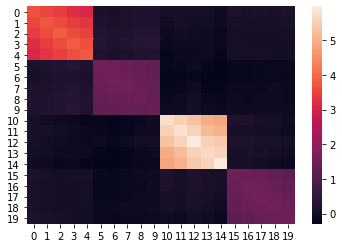

true Sigma
Best MSE we can have (in our dream):  tensor(0.0324)


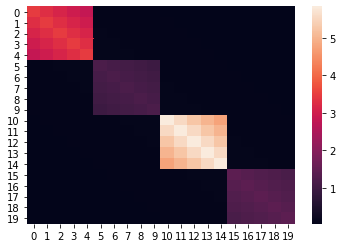

In [123]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(true_Sigma.to(torch.device('cpu')))
MLE_Sigma = torch.mean((Sigma_MLE.to(device)-true_Sigma)**2)
print('Best MSE we can have (in our dream): ', MLE_Sigma)

In [197]:
model= fastPLNPCA()
model.fit(data, 10000,p, verbose = True, lr = 0.3)

Iteration number:  0
-------UPDATE-------
ELBO :  -265634346367.34045
Delta :  -265634346366.34045
MSE_Sigma : tensor(2.1076, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.7853, grad_fn=<MeanBackward0>)
Iteration number:  10
-------UPDATE-------
ELBO :  630422.67216
Delta :  6159.177850570297
MSE_Sigma : tensor(1.0359, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.6469, grad_fn=<MeanBackward0>)
Iteration number:  20
-------UPDATE-------
ELBO :  657028.17411
Delta :  407.11513659439515
MSE_Sigma : tensor(1.0359, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.6024, grad_fn=<MeanBackward0>)
Iteration number:  30
-------UPDATE-------
ELBO :  658637.99627
Delta :  80.51807857037056
MSE_Sigma : tensor(1.0300, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.5504, grad_fn=<MeanBackward0>)
Iteration number:  40
-------UPDATE-------
ELBO :  659226.31063
Delta :  44.984558493830264
MSE_Sigma : tensor(1.0329, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.5000, grad_fn=<MeanBackward0>)
Iteration number:  5

Iteration number:  470
-------UPDATE-------
ELBO :  661989.19513
Delta :  1.195607143570669
MSE_Sigma : tensor(0.8576, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2434, grad_fn=<MeanBackward0>)
Iteration number:  480
-------UPDATE-------
ELBO :  662000.36756
Delta :  1.245699287741445
MSE_Sigma : tensor(0.8601, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2426, grad_fn=<MeanBackward0>)
Iteration number:  490
-------UPDATE-------
ELBO :  662012.55181
Delta :  1.2251263826619834
MSE_Sigma : tensor(0.8625, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2413, grad_fn=<MeanBackward0>)
Iteration number:  500
-------UPDATE-------
ELBO :  662024.73413
Delta :  1.2971217468148097
MSE_Sigma : tensor(0.8652, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2396, grad_fn=<MeanBackward0>)
Iteration number:  510
-------UPDATE-------
ELBO :  662036.65178
Delta :  1.2404922216665
MSE_Sigma : tensor(0.8678, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2380, grad_fn=<MeanBackward0>)
Iteration number:  520
--

Iteration number:  980
-------UPDATE-------
ELBO :  662388.76786
Delta :  0.9252697271294892
MSE_Sigma : tensor(0.8455, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2146, grad_fn=<MeanBackward0>)
Iteration number:  990
-------UPDATE-------
ELBO :  662399.26087
Delta :  1.339214270352386
MSE_Sigma : tensor(0.8443, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2145, grad_fn=<MeanBackward0>)
Iteration number:  1000
-------UPDATE-------
ELBO :  662409.31292
Delta :  0.8793569399276748
MSE_Sigma : tensor(0.8427, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2144, grad_fn=<MeanBackward0>)
Iteration number:  1010
-------UPDATE-------
ELBO :  662418.22879
Delta :  0.8232755135977641
MSE_Sigma : tensor(0.8430, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2143, grad_fn=<MeanBackward0>)
Iteration number:  1020
-------UPDATE-------
ELBO :  662425.11369
Delta :  0.7207225733436644
MSE_Sigma : tensor(0.8427, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2135, grad_fn=<MeanBackward0>)
Iteration number: 

Iteration number:  1500
-------UPDATE-------
ELBO :  662587.13997
Delta :  0.211585788638331
MSE_Sigma : tensor(0.7970, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2001, grad_fn=<MeanBackward0>)
Iteration number:  1510
-------UPDATE-------
ELBO :  662588.40802
Delta :  0.13120014674495906
MSE_Sigma : tensor(0.7966, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1999, grad_fn=<MeanBackward0>)
Iteration number:  1520
-------UPDATE-------
ELBO :  662590.08089
Delta :  0.19737501756753772
MSE_Sigma : tensor(0.7962, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1995, grad_fn=<MeanBackward0>)
Iteration number:  1530
-------UPDATE-------
ELBO :  662591.64297
Delta :  0.1620416877558455
MSE_Sigma : tensor(0.7955, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1994, grad_fn=<MeanBackward0>)
Iteration number:  1540
-------UPDATE-------
ELBO :  662592.90415
Delta :  0.13391538616269827
MSE_Sigma : tensor(0.7949, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1992, grad_fn=<MeanBackward0>)
Iteration num

Iteration number:  1930
-------UPDATE-------
ELBO :  662643.26237
Delta :  0.1003673659870401
MSE_Sigma : tensor(0.7355, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1915, grad_fn=<MeanBackward0>)
Iteration number:  1940
-------UPDATE-------
ELBO :  662644.18732
Delta :  -0.04854178603272885
MSE_Sigma : tensor(0.7332, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1912, grad_fn=<MeanBackward0>)
Iteration number:  1950
-------UPDATE-------
ELBO :  662645.22379
Delta :  0.08196847594808787
MSE_Sigma : tensor(0.7312, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1909, grad_fn=<MeanBackward0>)
Iteration number:  1960
-------UPDATE-------
ELBO :  662646.16923
Delta :  0.09716936922632158
MSE_Sigma : tensor(0.7293, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1907, grad_fn=<MeanBackward0>)
Iteration number:  1970
-------UPDATE-------
ELBO :  662647.31058
Delta :  0.016911235521547496
MSE_Sigma : tensor(0.7272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1903, grad_fn=<MeanBackward0>)
Iteration

Iteration number:  2350
-------UPDATE-------
ELBO :  662679.7904
Delta :  0.05721313878893852
MSE_Sigma : tensor(0.6722, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1851, grad_fn=<MeanBackward0>)
Iteration number:  2360
-------UPDATE-------
ELBO :  662680.60324
Delta :  0.09586331876926124
MSE_Sigma : tensor(0.6715, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1850, grad_fn=<MeanBackward0>)
Iteration number:  2370
-------UPDATE-------
ELBO :  662681.44709
Delta :  0.06044200551696122
MSE_Sigma : tensor(0.6707, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1850, grad_fn=<MeanBackward0>)
Iteration number:  2380
-------UPDATE-------
ELBO :  662682.1105
Delta :  0.07044430368114263
MSE_Sigma : tensor(0.6699, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1850, grad_fn=<MeanBackward0>)
Iteration number:  2390
-------UPDATE-------
ELBO :  662682.94799
Delta :  0.11126185464672744
MSE_Sigma : tensor(0.6686, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1850, grad_fn=<MeanBackward0>)
Iteration nu

Iteration number:  2770
-------UPDATE-------
ELBO :  662726.9305
Delta :  0.21809303993359208
MSE_Sigma : tensor(0.6106, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1834, grad_fn=<MeanBackward0>)
Iteration number:  2780
-------UPDATE-------
ELBO :  662728.47144
Delta :  0.10861967736855149
MSE_Sigma : tensor(0.6091, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1834, grad_fn=<MeanBackward0>)
Iteration number:  2790
-------UPDATE-------
ELBO :  662730.08351
Delta :  0.2181798000819981
MSE_Sigma : tensor(0.6077, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1833, grad_fn=<MeanBackward0>)
Iteration number:  2800
-------UPDATE-------
ELBO :  662732.27766
Delta :  0.17795306257903576
MSE_Sigma : tensor(0.6064, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1831, grad_fn=<MeanBackward0>)
Iteration number:  2810
-------UPDATE-------
ELBO :  662733.94661
Delta :  0.15630327246617526
MSE_Sigma : tensor(0.6052, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1831, grad_fn=<MeanBackward0>)
Iteration nu

Iteration number:  3200
-------UPDATE-------
ELBO :  662832.80292
Delta :  0.1361211333423853
MSE_Sigma : tensor(0.5106, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1791, grad_fn=<MeanBackward0>)
Iteration number:  3210
-------UPDATE-------
ELBO :  662833.91895
Delta :  0.12711612356361002
MSE_Sigma : tensor(0.5079, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1791, grad_fn=<MeanBackward0>)
Iteration number:  3220
-------UPDATE-------
ELBO :  662834.93567
Delta :  0.09520485438406467
MSE_Sigma : tensor(0.5064, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1790, grad_fn=<MeanBackward0>)
Iteration number:  3230
-------UPDATE-------
ELBO :  662835.99404
Delta :  0.132511893985793
MSE_Sigma : tensor(0.5044, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1790, grad_fn=<MeanBackward0>)
Iteration number:  3240
-------UPDATE-------
ELBO :  662837.57363
Delta :  0.15287967619951814
MSE_Sigma : tensor(0.5013, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1790, grad_fn=<MeanBackward0>)
Iteration num

Iteration number:  3700
-------UPDATE-------
ELBO :  662941.32072
Delta :  0.3175956787308678
MSE_Sigma : tensor(0.4190, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1795, grad_fn=<MeanBackward0>)
Iteration number:  3710
-------UPDATE-------
ELBO :  662944.0727
Delta :  0.28943982685450464
MSE_Sigma : tensor(0.4188, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1795, grad_fn=<MeanBackward0>)
Iteration number:  3720
-------UPDATE-------
ELBO :  662947.20971
Delta :  0.3121072503272444
MSE_Sigma : tensor(0.4185, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1796, grad_fn=<MeanBackward0>)
Iteration number:  3730
-------UPDATE-------
ELBO :  662950.24013
Delta :  0.34180417959578335
MSE_Sigma : tensor(0.4182, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1795, grad_fn=<MeanBackward0>)
Iteration number:  3740
-------UPDATE-------
ELBO :  662954.44048
Delta :  0.4149802461033687
MSE_Sigma : tensor(0.4179, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1794, grad_fn=<MeanBackward0>)
Iteration numb

Iteration number:  4220
-------UPDATE-------
ELBO :  662986.97622
Delta :  0.041052165208384395
MSE_Sigma : tensor(0.3718, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  4230
-------UPDATE-------
ELBO :  662987.40904
Delta :  0.047781795845367014
MSE_Sigma : tensor(0.3712, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  4240
-------UPDATE-------
ELBO :  662987.86175
Delta :  0.048357315827161074
MSE_Sigma : tensor(0.3703, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  4250
-------UPDATE-------
ELBO :  662988.31435
Delta :  0.039956794236786664
MSE_Sigma : tensor(0.3695, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  4260
-------UPDATE-------
ELBO :  662988.74241
Delta :  0.04030643473379314
MSE_Sigma : tensor(0.3688, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iterat

Iteration number:  4700
-------UPDATE-------
ELBO :  663003.99
Delta :  0.036892854142934084
MSE_Sigma : tensor(0.3424, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1774, grad_fn=<MeanBackward0>)
Iteration number:  4710
-------UPDATE-------
ELBO :  663004.31815
Delta :  0.03264277474954724
MSE_Sigma : tensor(0.3414, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1774, grad_fn=<MeanBackward0>)
Iteration number:  4720
-------UPDATE-------
ELBO :  663004.60389
Delta :  0.028092977940104902
MSE_Sigma : tensor(0.3405, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1774, grad_fn=<MeanBackward0>)
Iteration number:  4730
-------UPDATE-------
ELBO :  663004.89066
Delta :  0.02582653984427452
MSE_Sigma : tensor(0.3395, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1774, grad_fn=<MeanBackward0>)
Iteration number:  4740
-------UPDATE-------
ELBO :  663005.17076
Delta :  0.026938686496578157
MSE_Sigma : tensor(0.3388, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1774, grad_fn=<MeanBackward0>)
Iteration 

Iteration number:  5190
-------UPDATE-------
ELBO :  663017.92656
Delta :  0.02206501131877303
MSE_Sigma : tensor(0.2958, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1778, grad_fn=<MeanBackward0>)
Iteration number:  5200
-------UPDATE-------
ELBO :  663018.1625
Delta :  0.030520027154125273
MSE_Sigma : tensor(0.2948, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1778, grad_fn=<MeanBackward0>)
Iteration number:  5210
-------UPDATE-------
ELBO :  663018.41751
Delta :  0.02510495122987777
MSE_Sigma : tensor(0.2939, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1778, grad_fn=<MeanBackward0>)
Iteration number:  5220
-------UPDATE-------
ELBO :  663018.65941
Delta :  0.02045578195247799
MSE_Sigma : tensor(0.2929, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1778, grad_fn=<MeanBackward0>)
Iteration number:  5230
-------UPDATE-------
ELBO :  663018.87652
Delta :  0.021543459384702146
MSE_Sigma : tensor(0.2922, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1778, grad_fn=<MeanBackward0>)
Iteration

Iteration number:  5660
-------UPDATE-------
ELBO :  663029.18976
Delta :  0.01965202286373824
MSE_Sigma : tensor(0.2512, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  5670
-------UPDATE-------
ELBO :  663029.41333
Delta :  0.02421067573595792
MSE_Sigma : tensor(0.2504, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  5680
-------UPDATE-------
ELBO :  663029.63697
Delta :  0.021766076795756817
MSE_Sigma : tensor(0.2495, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  5690
-------UPDATE-------
ELBO :  663029.85943
Delta :  0.021477868664078414
MSE_Sigma : tensor(0.2481, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  5700
-------UPDATE-------
ELBO :  663030.08219
Delta :  0.018716427381150424
MSE_Sigma : tensor(0.2470, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iterati

Iteration number:  6110
-------UPDATE-------
ELBO :  663037.89879
Delta :  0.0203378030564636
MSE_Sigma : tensor(0.2077, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  6120
-------UPDATE-------
ELBO :  663038.08464
Delta :  0.018152841250412166
MSE_Sigma : tensor(0.2065, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  6130
-------UPDATE-------
ELBO :  663038.25662
Delta :  0.017106825718656182
MSE_Sigma : tensor(0.2054, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  6140
-------UPDATE-------
ELBO :  663038.43533
Delta :  0.013681288342922926
MSE_Sigma : tensor(0.2045, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iteration number:  6150
-------UPDATE-------
ELBO :  663038.58208
Delta :  0.014771030400879681
MSE_Sigma : tensor(0.2038, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1782, grad_fn=<MeanBackward0>)
Iterati

Iteration number:  6590
-------UPDATE-------
ELBO :  663045.20055
Delta :  0.012063326663337648
MSE_Sigma : tensor(0.1652, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1779, grad_fn=<MeanBackward0>)
Iteration number:  6600
-------UPDATE-------
ELBO :  663045.3297
Delta :  0.012581065180711448
MSE_Sigma : tensor(0.1643, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1779, grad_fn=<MeanBackward0>)
Iteration number:  6610
-------UPDATE-------
ELBO :  663045.46909
Delta :  0.01151232235133648
MSE_Sigma : tensor(0.1634, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1779, grad_fn=<MeanBackward0>)
Iteration number:  6620
-------UPDATE-------
ELBO :  663045.59456
Delta :  0.012956852093338966
MSE_Sigma : tensor(0.1626, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1778, grad_fn=<MeanBackward0>)
Iteration number:  6630
-------UPDATE-------
ELBO :  663045.70844
Delta :  0.010974314878694713
MSE_Sigma : tensor(0.1620, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1778, grad_fn=<MeanBackward0>)
Iterati

MSE_beta : tensor(0.1773, grad_fn=<MeanBackward0>)
Iteration number:  7080
-------UPDATE-------
ELBO :  663050.53524
Delta :  0.008531652390956879
MSE_Sigma : tensor(0.1290, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  7090
-------UPDATE-------
ELBO :  663050.6246
Delta :  0.006517915637232363
MSE_Sigma : tensor(0.1283, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  7100
-------UPDATE-------
ELBO :  663050.70297
Delta :  0.006311178673058748
MSE_Sigma : tensor(0.1277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  7110
-------UPDATE-------
ELBO :  663050.7832
Delta :  0.008679228834807873
MSE_Sigma : tensor(0.1272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1772, grad_fn=<MeanBackward0>)
Iteration number:  7120
-------UPDATE-------
ELBO :  663050.87634
Delta :  0.0077808654168620706
MSE_Sigma : tensor(0.1264, grad_fn=<MeanBackward0>)
MSE_be

Iteration number:  7580
-------UPDATE-------
ELBO :  663053.75489
Delta :  0.004545213188976049
MSE_Sigma : tensor(0.1035, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1755, grad_fn=<MeanBackward0>)
Iteration number:  7590
-------UPDATE-------
ELBO :  663053.80149
Delta :  0.0042008517775684595
MSE_Sigma : tensor(0.1031, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1754, grad_fn=<MeanBackward0>)
Iteration number:  7600
-------UPDATE-------
ELBO :  663053.85005
Delta :  0.004570033284835517
MSE_Sigma : tensor(0.1026, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1754, grad_fn=<MeanBackward0>)
Iteration number:  7610
-------UPDATE-------
ELBO :  663053.90341
Delta :  0.004808885511010885
MSE_Sigma : tensor(0.1021, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1753, grad_fn=<MeanBackward0>)
Iteration number:  7620
-------UPDATE-------
ELBO :  663053.94194
Delta :  0.00436693278606981
MSE_Sigma : tensor(0.1018, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1753, grad_fn=<MeanBackward0>)
Itera

Iteration number:  8060
-------UPDATE-------
ELBO :  663055.79718
Delta :  0.006073941709473729
MSE_Sigma : tensor(0.0838, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1731, grad_fn=<MeanBackward0>)
Iteration number:  8070
-------UPDATE-------
ELBO :  663055.82171
Delta :  0.002512285253033042
MSE_Sigma : tensor(0.0836, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1730, grad_fn=<MeanBackward0>)
Iteration number:  8080
-------UPDATE-------
ELBO :  663055.84412
Delta :  0.0023090995382517576
MSE_Sigma : tensor(0.0834, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1730, grad_fn=<MeanBackward0>)
Iteration number:  8090
-------UPDATE-------
ELBO :  663055.87621
Delta :  0.0040930891409516335
MSE_Sigma : tensor(0.0831, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1730, grad_fn=<MeanBackward0>)
Iteration number:  8100
-------UPDATE-------
ELBO :  663055.92031
Delta :  0.005191836040467024
MSE_Sigma : tensor(0.0826, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1729, grad_fn=<MeanBackward0>)
Ite

MSE_Sigma : tensor(0.0706, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1710, grad_fn=<MeanBackward0>)
Iteration number:  8520
-------UPDATE-------
ELBO :  663057.05493
Delta :  0.002342236926779151
MSE_Sigma : tensor(0.0704, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1709, grad_fn=<MeanBackward0>)
Iteration number:  8530
-------UPDATE-------
ELBO :  663057.07528
Delta :  0.0018003423465415835
MSE_Sigma : tensor(0.0701, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1709, grad_fn=<MeanBackward0>)
Iteration number:  8540
-------UPDATE-------
ELBO :  663057.09733
Delta :  0.0023656556149944663
MSE_Sigma : tensor(0.0699, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1709, grad_fn=<MeanBackward0>)
Iteration number:  8550
-------UPDATE-------
ELBO :  663057.12194
Delta :  0.0025888789677992463
MSE_Sigma : tensor(0.0696, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1708, grad_fn=<MeanBackward0>)
Iteration number:  8560
-------UPDATE-------
ELBO :  663057.14543
Delta :  0.0016552956076338887
M

Iteration number:  8970
-------UPDATE-------
ELBO :  663057.90448
Delta :  0.001809552893973887
MSE_Sigma : tensor(0.0602, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1692, grad_fn=<MeanBackward0>)
Iteration number:  8980
-------UPDATE-------
ELBO :  663057.92105
Delta :  0.0017006548587232828
MSE_Sigma : tensor(0.0600, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1692, grad_fn=<MeanBackward0>)
Iteration number:  8990
-------UPDATE-------
ELBO :  663057.9355
Delta :  0.0013387304497882724
MSE_Sigma : tensor(0.0598, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1691, grad_fn=<MeanBackward0>)
Iteration number:  9000
-------UPDATE-------
ELBO :  663057.95263
Delta :  0.0018843201687559485
MSE_Sigma : tensor(0.0597, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1691, grad_fn=<MeanBackward0>)
Iteration number:  9010
-------UPDATE-------
ELBO :  663057.96683
Delta :  0.0010535428300499916
MSE_Sigma : tensor(0.0595, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1691, grad_fn=<MeanBackward0>)
It

Iteration number:  9460
-------UPDATE-------
ELBO :  663058.46289
Delta :  0.0011845877161249518
MSE_Sigma : tensor(0.0530, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1678, grad_fn=<MeanBackward0>)
Iteration number:  9470
-------UPDATE-------
ELBO :  663058.47199
Delta :  0.0009972869884222746
MSE_Sigma : tensor(0.0528, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1678, grad_fn=<MeanBackward0>)
Iteration number:  9480
-------UPDATE-------
ELBO :  663058.48195
Delta :  0.0009163690265268087
MSE_Sigma : tensor(0.0527, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1677, grad_fn=<MeanBackward0>)
Iteration number:  9490
-------UPDATE-------
ELBO :  663058.49015
Delta :  0.00048246770165860653
MSE_Sigma : tensor(0.0526, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1677, grad_fn=<MeanBackward0>)
Iteration number:  9500
-------UPDATE-------
ELBO :  663058.4983
Delta :  0.0009834186639636755
MSE_Sigma : tensor(0.0524, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1677, grad_fn=<MeanBackward0>)


Iteration number:  9950
-------UPDATE-------
ELBO :  663058.82873
Delta :  0.00038425938691943884
MSE_Sigma : tensor(0.0472, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1664, grad_fn=<MeanBackward0>)
Iteration number:  9960
-------UPDATE-------
ELBO :  663058.83312
Delta :  0.0003988259704783559
MSE_Sigma : tensor(0.0471, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1664, grad_fn=<MeanBackward0>)
Iteration number:  9970
-------UPDATE-------
ELBO :  663058.83887
Delta :  0.000624324195086956
MSE_Sigma : tensor(0.0470, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1664, grad_fn=<MeanBackward0>)
Iteration number:  9980
-------UPDATE-------
ELBO :  663058.8447
Delta :  0.0005640211747959256
MSE_Sigma : tensor(0.0469, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1663, grad_fn=<MeanBackward0>)
Iteration number:  9990
-------UPDATE-------
ELBO :  663058.85065
Delta :  0.0003935651620849967
MSE_Sigma : tensor(0.0468, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1663, grad_fn=<MeanBackward0>)
-

In [199]:
model_VEM = fastPLNPCA()
model_VEM.VEM(data, 30000,N_iter_var = 1,N_iter_mod = 15, q = p, verbose = True, lr_var = 1, lr_mod = 0.1)

Iteration number:  0
-------UPDATE-------
ELBO :  455975.34272
Delta :  1718.2655358735938
MSE_Sigma : tensor(2.2227, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.9599, grad_fn=<MeanBackward0>)
Iteration number:  10
-------UPDATE-------
ELBO :  655411.65646
Delta :  22.890895122429356
MSE_Sigma : tensor(2.3731, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.4325, grad_fn=<MeanBackward0>)
Iteration number:  20
-------UPDATE-------
ELBO :  659288.65118
Delta :  3.461429479648359
MSE_Sigma : tensor(2.2038, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.3371, grad_fn=<MeanBackward0>)
Iteration number:  30
-------UPDATE-------
ELBO :  660297.23827
Delta :  1.1813873139908537
MSE_Sigma : tensor(2.0669, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2917, grad_fn=<MeanBackward0>)
Iteration number:  40
-------UPDATE-------
ELBO :  660781.49469
Delta :  0.5701646936358884
MSE_Sigma : tensor(1.9665, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2590, grad_fn=<MeanBackward0>)
Iteration number:  50
-----

Iteration number:  420
-------UPDATE-------
ELBO :  662802.75545
Delta :  0.04069761431310326
MSE_Sigma : tensor(0.9814, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1600, grad_fn=<MeanBackward0>)
Iteration number:  430
-------UPDATE-------
ELBO :  662815.00002
Delta :  0.04537756135687232
MSE_Sigma : tensor(0.9623, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1604, grad_fn=<MeanBackward0>)
Iteration number:  440
-------UPDATE-------
ELBO :  662827.32006
Delta :  0.05656399892177433
MSE_Sigma : tensor(0.9414, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1610, grad_fn=<MeanBackward0>)
Iteration number:  450
-------UPDATE-------
ELBO :  662841.02406
Delta :  0.028105977806262672
MSE_Sigma : tensor(0.9205, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1611, grad_fn=<MeanBackward0>)
Iteration number:  460
-------UPDATE-------
ELBO :  662855.93322
Delta :  0.025297507410869002
MSE_Sigma : tensor(0.8995, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1605, grad_fn=<MeanBackward0>)
Iteration num

Iteration number:  840
-------UPDATE-------
ELBO :  663013.84615
Delta :  0.002163618220947683
MSE_Sigma : tensor(0.5056, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1547, grad_fn=<MeanBackward0>)
Iteration number:  850
-------UPDATE-------
ELBO :  663014.61957
Delta :  0.002081974409520626
MSE_Sigma : tensor(0.5001, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1546, grad_fn=<MeanBackward0>)
Iteration number:  860
-------UPDATE-------
ELBO :  663015.44063
Delta :  0.0020631890511140227
MSE_Sigma : tensor(0.4943, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1545, grad_fn=<MeanBackward0>)
Iteration number:  870
-------UPDATE-------
ELBO :  663016.14838
Delta :  0.0018991752294823527
MSE_Sigma : tensor(0.4896, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1544, grad_fn=<MeanBackward0>)
Iteration number:  880
-------UPDATE-------
ELBO :  663016.81997
Delta :  0.001578322029672563
MSE_Sigma : tensor(0.4844, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1542, grad_fn=<MeanBackward0>)
Iteratio

Iteration number:  1270
-------UPDATE-------
ELBO :  663034.48745
Delta :  0.0011987759498879313
MSE_Sigma : tensor(0.3407, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1486, grad_fn=<MeanBackward0>)
Iteration number:  1280
-------UPDATE-------
ELBO :  663034.77006
Delta :  0.0004718585405498743
MSE_Sigma : tensor(0.3385, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1485, grad_fn=<MeanBackward0>)
Iteration number:  1290
-------UPDATE-------
ELBO :  663035.05802
Delta :  0.00039821502286940813
MSE_Sigma : tensor(0.3363, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1484, grad_fn=<MeanBackward0>)
Iteration number:  1300
-------UPDATE-------
ELBO :  663035.29083
Delta :  0.0002961278660222888
MSE_Sigma : tensor(0.3344, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  1310
-------UPDATE-------
ELBO :  663035.55543
Delta :  0.00042091181967407465
MSE_Sigma : tensor(0.3317, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>

Iteration number:  1690
-------UPDATE-------
ELBO :  663043.52731
Delta :  0.0005345518002286553
MSE_Sigma : tensor(0.2468, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1456, grad_fn=<MeanBackward0>)
Iteration number:  1700
-------UPDATE-------
ELBO :  663043.70772
Delta :  0.0002651740796864033
MSE_Sigma : tensor(0.2445, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1456, grad_fn=<MeanBackward0>)
Iteration number:  1710
-------UPDATE-------
ELBO :  663043.88701
Delta :  0.00010437844321131706
MSE_Sigma : tensor(0.2426, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1456, grad_fn=<MeanBackward0>)
Iteration number:  1720
-------UPDATE-------
ELBO :  663044.06535
Delta :  0.00043030327651649714
MSE_Sigma : tensor(0.2406, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1455, grad_fn=<MeanBackward0>)
Iteration number:  1730
-------UPDATE-------
ELBO :  663044.20787
Delta :  0.00016927032265812159
MSE_Sigma : tensor(0.2392, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1455, grad_fn=<MeanBackward0

Iteration number:  2110
-------UPDATE-------
ELBO :  663048.8935
Delta :  0.00013797939755022526
MSE_Sigma : tensor(0.1836, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0>)
Iteration number:  2120
-------UPDATE-------
ELBO :  663049.00121
Delta :  0.00010089448187500238
MSE_Sigma : tensor(0.1823, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0>)
Iteration number:  2130
-------UPDATE-------
ELBO :  663049.09567
Delta :  7.720454595983028e-05
MSE_Sigma : tensor(0.1812, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0>)
Iteration number:  2140
-------UPDATE-------
ELBO :  663049.18982
Delta :  0.00014086079318076372
MSE_Sigma : tensor(0.1799, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0>)
Iteration number:  2150
-------UPDATE-------
ELBO :  663049.28435
Delta :  0.00018345110584050417
MSE_Sigma : tensor(0.1789, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0

Iteration number:  2530
-------UPDATE-------
ELBO :  663052.36102
Delta :  8.721905760467052e-05
MSE_Sigma : tensor(0.1383, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1423, grad_fn=<MeanBackward0>)
Iteration number:  2540
-------UPDATE-------
ELBO :  663052.43682
Delta :  0.00011096568778157234
MSE_Sigma : tensor(0.1374, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1423, grad_fn=<MeanBackward0>)
Iteration number:  2550
-------UPDATE-------
ELBO :  663052.50117
Delta :  0.00010601838584989309
MSE_Sigma : tensor(0.1366, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1423, grad_fn=<MeanBackward0>)
Iteration number:  2560
-------UPDATE-------
ELBO :  663052.56079
Delta :  7.202813867479563e-05
MSE_Sigma : tensor(0.1358, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1422, grad_fn=<MeanBackward0>)
Iteration number:  2570
-------UPDATE-------
ELBO :  663052.63608
Delta :  0.000198870780877769
MSE_Sigma : tensor(0.1345, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1422, grad_fn=<MeanBackward0>)

Iteration number:  2950
-------UPDATE-------
ELBO :  663054.61544
Delta :  3.2916548661887646e-05
MSE_Sigma : tensor(0.1064, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  2960
-------UPDATE-------
ELBO :  663054.66687
Delta :  1.6085687093436718e-05
MSE_Sigma : tensor(0.1057, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  2970
-------UPDATE-------
ELBO :  663054.70352
Delta :  3.270967863500118e-05
MSE_Sigma : tensor(0.1052, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  2980
-------UPDATE-------
ELBO :  663054.74085
Delta :  5.79033512622118e-05
MSE_Sigma : tensor(0.1046, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  2990
-------UPDATE-------
ELBO :  663054.7905
Delta :  8.174416143447161e-05
MSE_Sigma : tensor(0.1039, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)


Iteration number:  3370
-------UPDATE-------
ELBO :  663056.16497
Delta :  1.5004421584308147e-05
MSE_Sigma : tensor(0.0837, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1417, grad_fn=<MeanBackward0>)
Iteration number:  3380
-------UPDATE-------
ELBO :  663056.19384
Delta :  2.5698449462652206e-05
MSE_Sigma : tensor(0.0833, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1417, grad_fn=<MeanBackward0>)
Iteration number:  3390
-------UPDATE-------
ELBO :  663056.22471
Delta :  6.059964653104544e-05
MSE_Sigma : tensor(0.0829, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1417, grad_fn=<MeanBackward0>)
Iteration number:  3400
-------UPDATE-------
ELBO :  663056.26109
Delta :  1.0755844414234161e-05
MSE_Sigma : tensor(0.0823, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1417, grad_fn=<MeanBackward0>)
Iteration number:  3410
-------UPDATE-------
ELBO :  663056.2988
Delta :  8.398131467401981e-05
MSE_Sigma : tensor(0.0816, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1417, grad_fn=<MeanBackward0>

Iteration number:  3790
-------UPDATE-------
ELBO :  663057.2504
Delta :  4.9597700126469135e-05
MSE_Sigma : tensor(0.0675, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  3800
-------UPDATE-------
ELBO :  663057.27631
Delta :  3.082072362303734e-05
MSE_Sigma : tensor(0.0672, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  3810
-------UPDATE-------
ELBO :  663057.29748
Delta :  1.739815343171358e-05
MSE_Sigma : tensor(0.0668, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  3820
-------UPDATE-------
ELBO :  663057.31499
Delta :  3.539456520229578e-05
MSE_Sigma : tensor(0.0665, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)
Iteration number:  3830
-------UPDATE-------
ELBO :  663057.33769
Delta :  1.434690784662962e-05
MSE_Sigma : tensor(0.0662, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1418, grad_fn=<MeanBackward0>)


Iteration number:  4210
-------UPDATE-------
ELBO :  663058.01271
Delta :  5.212496034801006e-06
MSE_Sigma : tensor(0.0552, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1422, grad_fn=<MeanBackward0>)
Iteration number:  4220
-------UPDATE-------
ELBO :  663058.02921
Delta :  4.465482197701931e-05
MSE_Sigma : tensor(0.0549, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1422, grad_fn=<MeanBackward0>)
Iteration number:  4230
-------UPDATE-------
ELBO :  663058.04558
Delta :  2.6914640329778194e-05
MSE_Sigma : tensor(0.0546, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1422, grad_fn=<MeanBackward0>)
Iteration number:  4240
-------UPDATE-------
ELBO :  663058.05896
Delta :  3.5073026083409786e-05
MSE_Sigma : tensor(0.0543, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1422, grad_fn=<MeanBackward0>)
Iteration number:  4250
-------UPDATE-------
ELBO :  663058.07032
Delta :  4.300964064896107e-06
MSE_Sigma : tensor(0.0541, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1422, grad_fn=<MeanBackward0>

Iteration number:  4620
-------UPDATE-------
ELBO :  663058.54442
Delta :  3.1419796869158745e-05
MSE_Sigma : tensor(0.0466, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1426, grad_fn=<MeanBackward0>)
Iteration number:  4630
-------UPDATE-------
ELBO :  663058.55403
Delta :  1.2028031051158905e-05
MSE_Sigma : tensor(0.0465, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1426, grad_fn=<MeanBackward0>)
Iteration number:  4640
-------UPDATE-------
ELBO :  663058.56699
Delta :  2.2888649255037308e-05
MSE_Sigma : tensor(0.0463, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1426, grad_fn=<MeanBackward0>)
Iteration number:  4650
-------UPDATE-------
ELBO :  663058.57858
Delta :  1.4522462151944637e-05
MSE_Sigma : tensor(0.0461, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1426, grad_fn=<MeanBackward0>)
Iteration number:  4660
-------UPDATE-------
ELBO :  663058.58904
Delta :  5.6639546528458595e-06
MSE_Sigma : tensor(0.0459, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1426, grad_fn=<MeanBackwar

Iteration number:  5040
-------UPDATE-------
ELBO :  663058.94788
Delta :  1.3558659702539444e-05
MSE_Sigma : tensor(0.0402, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1431, grad_fn=<MeanBackward0>)
Iteration number:  5050
-------UPDATE-------
ELBO :  663058.95542
Delta :  3.878725692629814e-06
MSE_Sigma : tensor(0.0401, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1431, grad_fn=<MeanBackward0>)
Iteration number:  5060
-------UPDATE-------
ELBO :  663058.96375
Delta :  1.263059675693512e-05
MSE_Sigma : tensor(0.0400, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1431, grad_fn=<MeanBackward0>)
Iteration number:  5070
-------UPDATE-------
ELBO :  663058.97186
Delta :  3.0201743356883526e-05
MSE_Sigma : tensor(0.0398, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1431, grad_fn=<MeanBackward0>)
Iteration number:  5080
-------UPDATE-------
ELBO :  663058.9783
Delta :  3.7818681448698044e-06
MSE_Sigma : tensor(0.0397, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1431, grad_fn=<MeanBackward0>

Iteration number:  5460
-------UPDATE-------
ELBO :  663059.23754
Delta :  5.539041012525558e-07
MSE_Sigma : tensor(0.0357, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0>)
Iteration number:  5470
-------UPDATE-------
ELBO :  663059.24248
Delta :  7.99400731921196e-06
MSE_Sigma : tensor(0.0357, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0>)
Iteration number:  5480
-------UPDATE-------
ELBO :  663059.24889
Delta :  1.7339945770800114e-05
MSE_Sigma : tensor(0.0356, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1436, grad_fn=<MeanBackward0>)
Iteration number:  5490
-------UPDATE-------
ELBO :  663059.25521
Delta :  7.80902337282896e-06
MSE_Sigma : tensor(0.0355, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1437, grad_fn=<MeanBackward0>)
Iteration number:  5500
-------UPDATE-------
ELBO :  663059.26088
Delta :  3.1996751204133034e-06
MSE_Sigma : tensor(0.0355, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1437, grad_fn=<MeanBackward0>)


Iteration number:  5880
-------UPDATE-------
ELBO :  663059.45291
Delta :  1.4794408343732357e-05
MSE_Sigma : tensor(0.0327, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1441, grad_fn=<MeanBackward0>)
Iteration number:  5890
-------UPDATE-------
ELBO :  663059.45853
Delta :  5.452078767120838e-06
MSE_Sigma : tensor(0.0327, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1441, grad_fn=<MeanBackward0>)
Iteration number:  5900
-------UPDATE-------
ELBO :  663059.46294
Delta :  6.4658233895897865e-06
MSE_Sigma : tensor(0.0326, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1442, grad_fn=<MeanBackward0>)
Iteration number:  5910
-------UPDATE-------
ELBO :  663059.46578
Delta :  1.3605458661913872e-06
MSE_Sigma : tensor(0.0325, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1442, grad_fn=<MeanBackward0>)
Iteration number:  5920
-------UPDATE-------
ELBO :  663059.46989
Delta :  1.4840858057141304e-05
MSE_Sigma : tensor(0.0325, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1442, grad_fn=<MeanBackward

Iteration number:  6300
-------UPDATE-------
ELBO :  663059.6083
Delta :  1.7040874809026718e-06
MSE_Sigma : tensor(0.0304, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1446, grad_fn=<MeanBackward0>)
Iteration number:  6310
-------UPDATE-------
ELBO :  663059.61156
Delta :  1.7348211258649826e-06
MSE_Sigma : tensor(0.0304, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1446, grad_fn=<MeanBackward0>)
Iteration number:  6320
-------UPDATE-------
ELBO :  663059.61436
Delta :  3.0494993552565575e-06
MSE_Sigma : tensor(0.0304, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1446, grad_fn=<MeanBackward0>)
Iteration number:  6330
-------UPDATE-------
ELBO :  663059.61741
Delta :  2.9525253921747208e-06
MSE_Sigma : tensor(0.0303, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1446, grad_fn=<MeanBackward0>)
Iteration number:  6340
-------UPDATE-------
ELBO :  663059.62083
Delta :  3.8049183785915375e-06
MSE_Sigma : tensor(0.0303, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1446, grad_fn=<MeanBackward

Iteration number:  6720
-------UPDATE-------
ELBO :  663059.71743
Delta :  9.203795343637466e-07
MSE_Sigma : tensor(0.0290, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1450, grad_fn=<MeanBackward0>)
Iteration number:  6730
-------UPDATE-------
ELBO :  663059.71987
Delta :  2.1437881514430046e-06
MSE_Sigma : tensor(0.0289, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1450, grad_fn=<MeanBackward0>)
Iteration number:  6740
-------UPDATE-------
ELBO :  663059.7222
Delta :  5.691545084118843e-06
MSE_Sigma : tensor(0.0289, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1450, grad_fn=<MeanBackward0>)
Iteration number:  6750
-------UPDATE-------
ELBO :  663059.72419
Delta :  1.4220131561160088e-06
MSE_Sigma : tensor(0.0289, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1450, grad_fn=<MeanBackward0>)
Iteration number:  6760
-------UPDATE-------
ELBO :  663059.72697
Delta :  4.559406079351902e-06
MSE_Sigma : tensor(0.0288, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1450, grad_fn=<MeanBackward0>)

Iteration number:  7140
-------UPDATE-------
ELBO :  663059.80137
Delta :  1.5725381672382355e-06
MSE_Sigma : tensor(0.0278, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1453, grad_fn=<MeanBackward0>)
Iteration number:  7150
-------UPDATE-------
ELBO :  663059.80306
Delta :  5.534384399652481e-07
MSE_Sigma : tensor(0.0278, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1454, grad_fn=<MeanBackward0>)
Iteration number:  7160
-------UPDATE-------
ELBO :  663059.80474
Delta :  3.2695243135094643e-06
MSE_Sigma : tensor(0.0278, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1454, grad_fn=<MeanBackward0>)
Iteration number:  7170
-------UPDATE-------
ELBO :  663059.80647
Delta :  3.0370429158210754e-06
MSE_Sigma : tensor(0.0277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1454, grad_fn=<MeanBackward0>)
Iteration number:  7180
-------UPDATE-------
ELBO :  663059.80795
Delta :  6.961636245250702e-07
MSE_Sigma : tensor(0.0277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1454, grad_fn=<MeanBackward0

Iteration number:  7560
-------UPDATE-------
ELBO :  663059.8616
Delta :  2.6565976440906525e-07
MSE_Sigma : tensor(0.0271, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1457, grad_fn=<MeanBackward0>)
Iteration number:  7570
-------UPDATE-------
ELBO :  663059.86284
Delta :  1.4331890270113945e-06
MSE_Sigma : tensor(0.0270, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1457, grad_fn=<MeanBackward0>)
Iteration number:  7580
-------UPDATE-------
ELBO :  663059.86394
Delta :  1.0881340131163597e-06
MSE_Sigma : tensor(0.0270, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1457, grad_fn=<MeanBackward0>)
Iteration number:  7590
-------UPDATE-------
ELBO :  663059.86489
Delta :  1.0087387636303902e-06
MSE_Sigma : tensor(0.0270, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1457, grad_fn=<MeanBackward0>)
Iteration number:  7600
-------UPDATE-------
ELBO :  663059.86593
Delta :  2.5958288460969925e-06
MSE_Sigma : tensor(0.0270, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1457, grad_fn=<MeanBackward

Iteration number:  7970
-------UPDATE-------
ELBO :  663059.90462
Delta :  1.4217803254723549e-06
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  7980
-------UPDATE-------
ELBO :  663059.90558
Delta :  2.4604378268122673e-06
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  7990
-------UPDATE-------
ELBO :  663059.90638
Delta :  5.704350769519806e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  8000
-------UPDATE-------
ELBO :  663059.90745
Delta :  1.3170065358281136e-06
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  8010
-------UPDATE-------
ELBO :  663059.9085
Delta :  5.995389074087143e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>

Iteration number:  8380
-------UPDATE-------
ELBO :  663059.93807
Delta :  8.153729140758514e-07
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  8390
-------UPDATE-------
ELBO :  663059.93859
Delta :  6.539048627018929e-07
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  8400
-------UPDATE-------
ELBO :  663059.93904
Delta :  -9.138602763414383e-08
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  8410
-------UPDATE-------
ELBO :  663059.93974
Delta :  9.881332516670227e-07
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  8420
-------UPDATE-------
ELBO :  663059.94042
Delta :  4.825415089726448e-07
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)

Iteration number:  8800
-------UPDATE-------
ELBO :  663059.96182
Delta :  2.243206836283207e-06
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  8810
-------UPDATE-------
ELBO :  663059.96229
Delta :  3.294553607702255e-07
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  8820
-------UPDATE-------
ELBO :  663059.96278
Delta :  2.682209014892578e-07
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  8830
-------UPDATE-------
ELBO :  663059.96328
Delta :  6.402842700481415e-08
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  8840
-------UPDATE-------
ELBO :  663059.96383
Delta :  6.185146048665047e-07
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1466, grad_fn=<MeanBackward0>)


Iteration number:  9210
-------UPDATE-------
ELBO :  663059.97881
Delta :  2.4854671210050583e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  9220
-------UPDATE-------
ELBO :  663059.97917
Delta :  3.647292032837868e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  9230
-------UPDATE-------
ELBO :  663059.9796
Delta :  1.6728881746530533e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  9240
-------UPDATE-------
ELBO :  663059.97994
Delta :  1.7904676496982574e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  9250
-------UPDATE-------
ELBO :  663059.98026
Delta :  5.075708031654358e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>

Iteration number:  9620
-------UPDATE-------
ELBO :  663059.99147
Delta :  3.1676609069108963e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  9630
-------UPDATE-------
ELBO :  663059.99171
Delta :  -5.4016709327697754e-08
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  9640
-------UPDATE-------
ELBO :  663059.992
Delta :  1.778826117515564e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  9650
-------UPDATE-------
ELBO :  663059.99225
Delta :  -1.9941944628953934e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  9660
-------UPDATE-------
ELBO :  663059.99252
Delta :  2.1210871636867523e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward

Iteration number:  10040
-------UPDATE-------
ELBO :  663060.0007
Delta :  1.223525032401085e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1471, grad_fn=<MeanBackward0>)
Iteration number:  10050
-------UPDATE-------
ELBO :  663060.00089
Delta :  2.5960616767406464e-08
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1472, grad_fn=<MeanBackward0>)
Iteration number:  10060
-------UPDATE-------
ELBO :  663060.00104
Delta :  -1.9278377294540405e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1472, grad_fn=<MeanBackward0>)
Iteration number:  10070
-------UPDATE-------
ELBO :  663060.00121
Delta :  2.835877239704132e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1472, grad_fn=<MeanBackward0>)
Iteration number:  10080
-------UPDATE-------
ELBO :  663060.00141
Delta :  -5.296897143125534e-08
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1472, grad_fn=<MeanBack

Iteration number:  10460
-------UPDATE-------
ELBO :  663060.00758
Delta :  2.416782081127167e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  10470
-------UPDATE-------
ELBO :  663060.00772
Delta :  3.521563485264778e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  10480
-------UPDATE-------
ELBO :  663060.00786
Delta :  -1.6903504729270935e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  10490
-------UPDATE-------
ELBO :  663060.00801
Delta :  -3.069872036576271e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  10500
-------UPDATE-------
ELBO :  663060.00814
Delta :  -2.6240013539791107e-07
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBa

Iteration number:  10870
-------UPDATE-------
ELBO :  663060.01288
Delta :  8.335337042808533e-08
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  10880
-------UPDATE-------
ELBO :  663060.01301
Delta :  1.548323780298233e-07
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  10890
-------UPDATE-------
ELBO :  663060.01312
Delta :  1.0756775736808777e-07
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  10900
-------UPDATE-------
ELBO :  663060.01324
Delta :  -6.181653589010239e-08
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  10910
-------UPDATE-------
ELBO :  663060.01334
Delta :  -3.4458935260772705e-08
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBac

Iteration number:  11290
-------UPDATE-------
ELBO :  663060.01709
Delta :  7.415656000375748e-08
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  11300
-------UPDATE-------
ELBO :  663060.01719
Delta :  -2.0838342607021332e-08
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  11310
-------UPDATE-------
ELBO :  663060.0173
Delta :  -2.4389009922742844e-07
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  11320
-------UPDATE-------
ELBO :  663060.01738
Delta :  -2.752058207988739e-07
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  11330
-------UPDATE-------
ELBO :  663060.01746
Delta :  -3.958120942115784e-08
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBa

Iteration number:  11710
-------UPDATE-------
ELBO :  663060.02032
Delta :  1.0652001947164536e-07
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1477, grad_fn=<MeanBackward0>)
Iteration number:  11720
-------UPDATE-------
ELBO :  663060.0204
Delta :  8.579809218645096e-08
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1477, grad_fn=<MeanBackward0>)
Iteration number:  11730
-------UPDATE-------
ELBO :  663060.02046
Delta :  1.7462298274040222e-08
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1477, grad_fn=<MeanBackward0>)
Iteration number:  11740
-------UPDATE-------
ELBO :  663060.02052
Delta :  6.158370524644852e-08
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1477, grad_fn=<MeanBackward0>)
Iteration number:  11750
-------UPDATE-------
ELBO :  663060.02058
Delta :  1.6100239008665085e-07
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1477, grad_fn=<MeanBackw

Iteration number:  12130
-------UPDATE-------
ELBO :  663060.02267
Delta :  -6.05359673500061e-09
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  12140
-------UPDATE-------
ELBO :  663060.02273
Delta :  -1.7439015209674835e-07
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  12150
-------UPDATE-------
ELBO :  663060.02277
Delta :  -1.8044374883174896e-07
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  12160
-------UPDATE-------
ELBO :  663060.02281
Delta :  3.771856427192688e-08
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  12170
-------UPDATE-------
ELBO :  663060.02285
Delta :  3.4528784453868866e-07
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBa

Iteration number:  12540
-------UPDATE-------
ELBO :  663060.02428
Delta :  -4.4587068259716034e-08
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  12550
-------UPDATE-------
ELBO :  663060.0243
Delta :  9.383074939250946e-08
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBackward0>)
Iteration number:  12560
-------UPDATE-------
ELBO :  663060.02432
Delta :  -1.2258533388376236e-07
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBackward0>)
Iteration number:  12570
-------UPDATE-------
ELBO :  663060.02434
Delta :  1.3667158782482147e-07
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBackward0>)
Iteration number:  12580
-------UPDATE-------
ELBO :  663060.02436
Delta :  1.234002411365509e-08
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBac

Iteration number:  12950
-------UPDATE-------
ELBO :  663060.02528
Delta :  3.8708094507455826e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBackward0>)
Iteration number:  12960
-------UPDATE-------
ELBO :  663060.0253
Delta :  1.6624107956886292e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBackward0>)
Iteration number:  12970
-------UPDATE-------
ELBO :  663060.02531
Delta :  -1.6263220459222794e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBackward0>)
Iteration number:  12980
-------UPDATE-------
ELBO :  663060.02533
Delta :  4.0081795305013657e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanBackward0>)
Iteration number:  12990
-------UPDATE-------
ELBO :  663060.02534
Delta :  -1.9907020032405853e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1479, grad_fn=<MeanB

Iteration number:  13360
-------UPDATE-------
ELBO :  663060.02593
Delta :  -2.8638169169425964e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13370
-------UPDATE-------
ELBO :  663060.02594
Delta :  -1.4994293451309204e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13380
-------UPDATE-------
ELBO :  663060.02596
Delta :  3.229361027479172e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13390
-------UPDATE-------
ELBO :  663060.02597
Delta :  8.416827768087387e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13400
-------UPDATE-------
ELBO :  663060.02598
Delta :  9.19681042432785e-09
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBack

Iteration number:  13780
-------UPDATE-------
ELBO :  663060.02646
Delta :  -2.6659108698368073e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13790
-------UPDATE-------
ELBO :  663060.02648
Delta :  8.556526154279709e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13800
-------UPDATE-------
ELBO :  663060.02649
Delta :  1.4191027730703354e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13810
-------UPDATE-------
ELBO :  663060.0265
Delta :  -1.0710209608078003e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  13820
-------UPDATE-------
ELBO :  663060.02651
Delta :  -1.234002411365509e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBa

Iteration number:  14200
-------UPDATE-------
ELBO :  663060.02687
Delta :  1.4621764421463013e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  14210
-------UPDATE-------
ELBO :  663060.02688
Delta :  -2.6542693376541138e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  14220
-------UPDATE-------
ELBO :  663060.02689
Delta :  -7.078051567077637e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  14230
-------UPDATE-------
ELBO :  663060.0269
Delta :  1.210719347000122e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  14240
-------UPDATE-------
ELBO :  663060.02691
Delta :  1.00000761449337e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackw

Iteration number:  14610
-------UPDATE-------
ELBO :  663060.0272
Delta :  -9.406358003616333e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  14620
-------UPDATE-------
ELBO :  663060.02721
Delta :  -1.180451363325119e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  14630
-------UPDATE-------
ELBO :  663060.02722
Delta :  2.3166649043560028e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  14640
-------UPDATE-------
ELBO :  663060.02723
Delta :  -8.847564458847046e-08
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  14650
-------UPDATE-------
ELBO :  663060.02724
Delta :  2.0116567611694336e-07
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBac

Iteration number:  15030
-------UPDATE-------
ELBO :  663060.02751
Delta :  -1.4854595065116882e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15040
-------UPDATE-------
ELBO :  663060.02751
Delta :  -8.451752364635468e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15050
-------UPDATE-------
ELBO :  663060.02752
Delta :  -2.444721758365631e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15060
-------UPDATE-------
ELBO :  663060.02752
Delta :  -1.4202669262886047e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15070
-------UPDATE-------
ELBO :  663060.02753
Delta :  3.573950380086899e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanB

Iteration number:  15450
-------UPDATE-------
ELBO :  663060.02773
Delta :  2.594897523522377e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15460
-------UPDATE-------
ELBO :  663060.02774
Delta :  2.1548476070165634e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15470
-------UPDATE-------
ELBO :  663060.02774
Delta :  1.0523945093154907e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15480
-------UPDATE-------
ELBO :  663060.02775
Delta :  2.448214218020439e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15490
-------UPDATE-------
ELBO :  663060.02775
Delta :  9.359791874885559e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackw

Iteration number:  15860
-------UPDATE-------
ELBO :  663060.02793
Delta :  -2.0605511963367462e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15870
-------UPDATE-------
ELBO :  663060.02793
Delta :  1.8510036170482635e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15880
-------UPDATE-------
ELBO :  663060.02794
Delta :  2.230517566204071e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15890
-------UPDATE-------
ELBO :  663060.02794
Delta :  6.452901288866997e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  15900
-------UPDATE-------
ELBO :  663060.02795
Delta :  3.537861630320549e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBack

Iteration number:  16270
-------UPDATE-------
ELBO :  663060.02808
Delta :  1.9511207938194275e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  16280
-------UPDATE-------
ELBO :  663060.02808
Delta :  -1.280568540096283e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1481, grad_fn=<MeanBackward0>)
Iteration number:  16290
-------UPDATE-------
ELBO :  663060.02808
Delta :  1.3154931366443634e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  16300
-------UPDATE-------
ELBO :  663060.02809
Delta :  -2.230517566204071e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  16310
-------UPDATE-------
ELBO :  663060.02809
Delta :  -7.369089871644974e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  16680
-------UPDATE-------
ELBO :  663060.02821
Delta :  6.710179150104523e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  16690
-------UPDATE-------
ELBO :  663060.02821
Delta :  2.4796463549137115e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  16700
-------UPDATE-------
ELBO :  663060.02821
Delta :  -2.7229543775320053e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  16710
-------UPDATE-------
ELBO :  663060.02822
Delta :  6.030313670635223e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  16720
-------UPDATE-------
ELBO :  663060.02822
Delta :  2.0954757928848267e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBac

Iteration number:  17090
-------UPDATE-------
ELBO :  663060.02833
Delta :  5.78584149479866e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17100
-------UPDATE-------
ELBO :  663060.02833
Delta :  4.540197551250458e-09
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17110
-------UPDATE-------
ELBO :  663060.02833
Delta :  1.2433156371116638e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17120
-------UPDATE-------
ELBO :  663060.02833
Delta :  -5.21540641784668e-08
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17130
-------UPDATE-------
ELBO :  663060.02834
Delta :  1.223525032401085e-07
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackwar

ELBO :  663060.02842
Delta :  9.569339454174042e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17510
-------UPDATE-------
ELBO :  663060.02842
Delta :  3.876630216836929e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17520
-------UPDATE-------
ELBO :  663060.02843
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17530
-------UPDATE-------
ELBO :  663060.02843
Delta :  -2.4330802261829376e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17540
-------UPDATE-------
ELBO :  663060.02843
Delta :  2.6333145797252655e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17550
-------UPDATE

Iteration number:  17910
-------UPDATE-------
ELBO :  663060.02851
Delta :  1.30385160446167e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17920
-------UPDATE-------
ELBO :  663060.02851
Delta :  2.451706677675247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17930
-------UPDATE-------
ELBO :  663060.02852
Delta :  -5.436595529317856e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17940
-------UPDATE-------
ELBO :  663060.02852
Delta :  5.005858838558197e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  17950
-------UPDATE-------
ELBO :  663060.02852
Delta :  7.404014468193054e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackwar

Iteration number:  18330
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.1886080503463745e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18340
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.4028046280145645e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18350
-------UPDATE-------
ELBO :  663060.02858
Delta :  4.493631422519684e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18360
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3294629752635956e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18370
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.015156835317612e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  18750
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.073364496231079e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18760
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.2898817658424377e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18770
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.87545844912529e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18780
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  18790
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBack

Iteration number:  19170
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19180
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19190
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19200
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3154931366443634e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19210
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanB

Iteration number:  19580
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19590
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19600
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19610
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  19620
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3166572898626328e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  20000
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20010
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9453076422214508e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20020
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20030
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20040
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3154931366443634e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mean

Iteration number:  20410
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20420
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20430
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20440
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20450
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9802322387695312e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  20830
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.991873770952225e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20840
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3085082173347473e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20850
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20860
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20870
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  21240
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3166572898626328e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21250
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21260
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21270
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9453076422214508e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21280
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mea

Iteration number:  21660
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3189855962991714e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21670
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21680
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21690
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9453076422214508e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  21700
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mea

Iteration number:  22080
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22090
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22100
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22110
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22120
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanB

Iteration number:  22500
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22510
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22520
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22530
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9336661100387573e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22540
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanB

Iteration number:  22920
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22930
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22940
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22950
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  22960
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mean

Iteration number:  23340
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23350
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23360
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23370
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23380
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mean

Iteration number:  23760
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3166572898626328e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23770
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9802322387695312e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23780
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23790
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  23800
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanB

Iteration number:  24180
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24190
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24200
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24210
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24220
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mean

Iteration number:  24600
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3189855962991714e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24610
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9802322387695312e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24620
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24630
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  24640
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mean

Iteration number:  25020
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3154931366443634e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25030
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25040
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3085082173347473e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25050
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25060
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mea

Iteration number:  25440
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25450
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9802322387695312e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25460
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25470
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25480
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanB

Iteration number:  25860
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3189855962991714e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25870
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25880
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3085082173347473e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25890
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9336661100387573e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  25900
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3131648302078247e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mea

Iteration number:  26280
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3154931366443634e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26290
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26300
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26310
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26320
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<Mea

Iteration number:  26690
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26700
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3154931366443634e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26710
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26720
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  26730
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9802322387695312e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  27110
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.015156835317612e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27120
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3166572898626328e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27130
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9453076422214508e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27140
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3085082173347473e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27150
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanB

Iteration number:  27520
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27530
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27540
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27550
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27560
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  27940
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27950
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.991873770952225e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27960
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27970
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9569491744041443e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  27980
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3120006769895554e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanB

Iteration number:  28360
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28370
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.003515303134918e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28380
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28390
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9802322387695312e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28400
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  28780
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28790
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.991873770952225e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28800
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28810
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  28820
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBac

Iteration number:  29200
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3096723705530167e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29210
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.026798367500305e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29220
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.317821443080902e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29230
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29240
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

Iteration number:  29620
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29630
-------UPDATE-------
ELBO :  663060.02858
Delta :  3.015156835317612e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29640
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.3189855962991714e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29650
-------UPDATE-------
ELBO :  663060.02858
Delta :  2.9685907065868378e-08
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  29660
-------UPDATE-------
ELBO :  663060.02858
Delta :  -1.310836523771286e-07
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

<ipython-input-23-57d7a833515b>:96: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ybound( lower=0, upper=0.7)


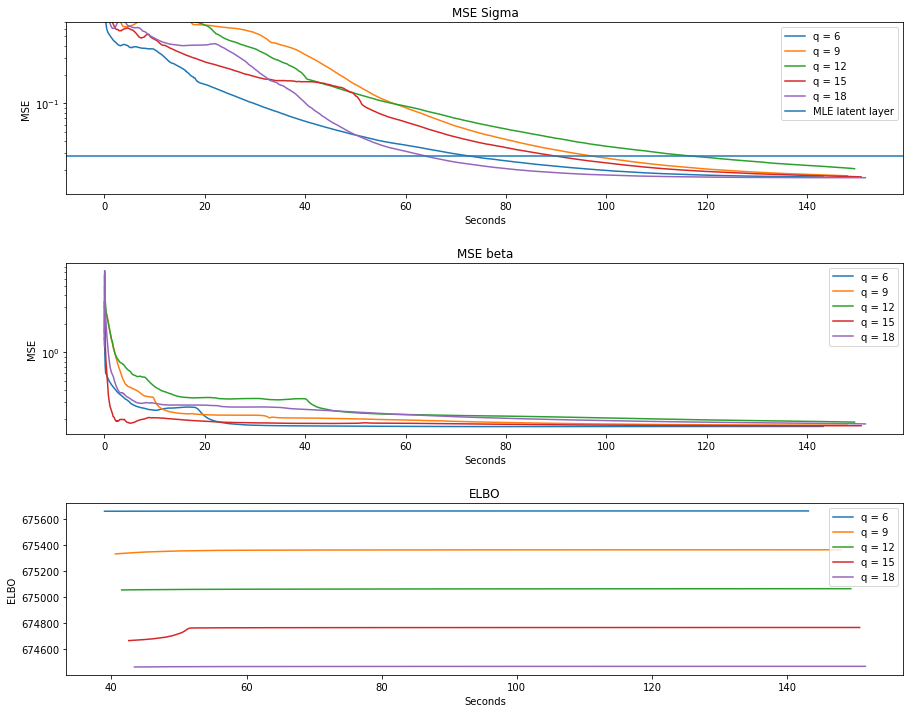

In [24]:
compare_models(result_dict,'', percentage_kept = 0.7)

In [7]:
dict_optimizers = {'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                   'Adamax' : torch.optim.Adamax,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop}

In [8]:
result_optimizers = launch_optimizers(dict_optimizers,300, 0.1)

NameError: name 'data' is not defined

In [13]:
dict_dimensions = dict()

for dim in range(5,p+1,3):
    dict_dimensions['q = ' +str(dim)] = dim 
dict_dimensions

{'q = 5': 5,
 'q = 8': 8,
 'q = 11': 11,
 'q = 14': 14,
 'q = 17': 17,
 'q = 20': 20}

In [14]:
result_dict = launch_dimensions(dict_dimensions,30000, 0.7)

<ipython-input-4-57d7a833515b>:96: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ybound( lower=0, upper=0.7)


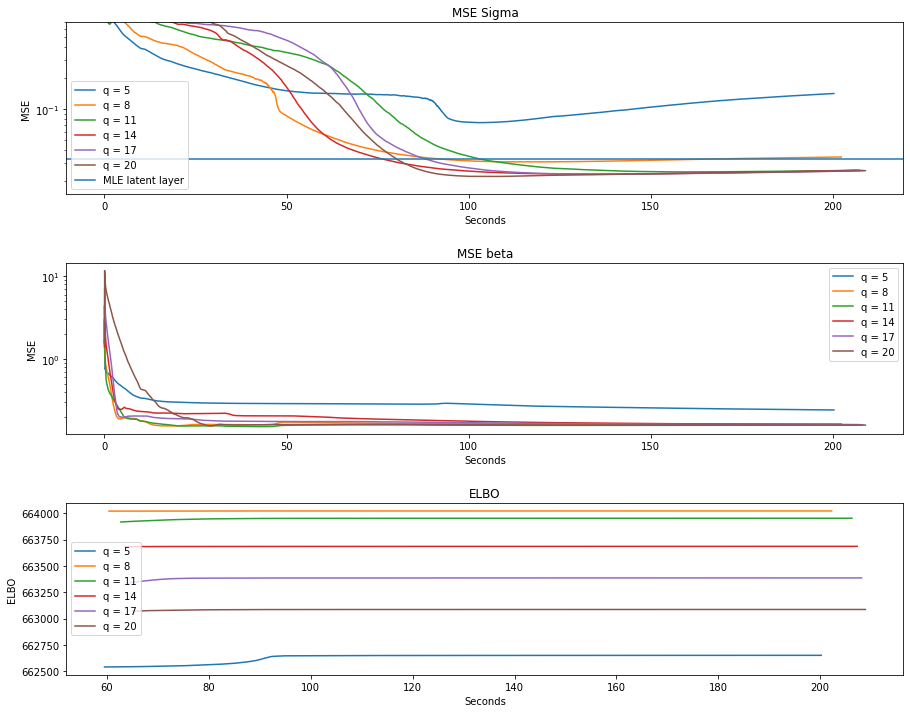

In [16]:
compare_models(result_dict,'Comparison_axes_second',percentage_kept = 0.7, save = False)

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+MC^{\top}) - \frac{1}{2} \operatorname{exp}\left(O+X\beta+MC^{\top}+\frac{(S \odot S)(C\odot C)^{\top}}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

In [11]:
model = fastPLNPCA()
model.fit(data, 30000,p//4, loss_choice = 'PCA', verbose = True, lr = 0.7)
model.print_MSE()

Iteration number:  0
-------UPDATE-------
ELBO :  -1186218942618.0867
Delta :  -1186218942617.0867
MSE_Sigma : tensor(2.8018, grad_fn=<MeanBackward0>)
MSE_beta : tensor(1.1626, grad_fn=<MeanBackward0>)
Iteration number:  10
-------UPDATE-------
ELBO :  630865.17633
Delta :  9033.060423692572
MSE_Sigma : tensor(1.0423, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.8882, grad_fn=<MeanBackward0>)
Iteration number:  20
-------UPDATE-------
ELBO :  667965.06798
Delta :  1329.191752735409
MSE_Sigma : tensor(0.8272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.7698, grad_fn=<MeanBackward0>)
Iteration number:  30
-------UPDATE-------
ELBO :  675350.70292
Delta :  574.957259945455
MSE_Sigma : tensor(0.7393, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.6885, grad_fn=<MeanBackward0>)
Iteration number:  40
-------UPDATE-------
ELBO :  677895.61678
Delta :  144.7462020283565
MSE_Sigma : tensor(0.6598, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.6477, grad_fn=<MeanBackward0>)
Iteration number:  50
-

Iteration number:  520
-------UPDATE-------
ELBO :  681278.82502
Delta :  0.6168869439279661
MSE_Sigma : tensor(0.4867, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.4621, grad_fn=<MeanBackward0>)
Iteration number:  530
-------UPDATE-------
ELBO :  681284.59182
Delta :  0.5948854230809957
MSE_Sigma : tensor(0.4867, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.4589, grad_fn=<MeanBackward0>)
Iteration number:  540
-------UPDATE-------
ELBO :  681289.94974
Delta :  0.47814957168884575
MSE_Sigma : tensor(0.4869, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.4554, grad_fn=<MeanBackward0>)
Iteration number:  550
-------UPDATE-------
ELBO :  681294.54485
Delta :  0.45618593180552125
MSE_Sigma : tensor(0.4881, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.4533, grad_fn=<MeanBackward0>)
Iteration number:  560
-------UPDATE-------
ELBO :  681299.03335
Delta :  0.42389758629724383
MSE_Sigma : tensor(0.4896, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.4508, grad_fn=<MeanBackward0>)
Iteration number:

Iteration number:  1050
-------UPDATE-------
ELBO :  681392.40712
Delta :  0.09033354942221195
MSE_Sigma : tensor(0.4594, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.3428, grad_fn=<MeanBackward0>)
Iteration number:  1060
-------UPDATE-------
ELBO :  681393.38492
Delta :  0.11077718785963953
MSE_Sigma : tensor(0.4584, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.3411, grad_fn=<MeanBackward0>)
Iteration number:  1070
-------UPDATE-------
ELBO :  681394.53362
Delta :  0.09689670079387724
MSE_Sigma : tensor(0.4579, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.3392, grad_fn=<MeanBackward0>)
Iteration number:  1080
-------UPDATE-------
ELBO :  681395.65727
Delta :  -0.005653534317389131
MSE_Sigma : tensor(0.4572, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.3374, grad_fn=<MeanBackward0>)
Iteration number:  1090
-------UPDATE-------
ELBO :  681396.79173
Delta :  0.09596683352719992
MSE_Sigma : tensor(0.4564, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.3356, grad_fn=<MeanBackward0>)
Iteratio

Iteration number:  1590
-------UPDATE-------
ELBO :  681435.80944
Delta :  0.06685402465518564
MSE_Sigma : tensor(0.3987, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2712, grad_fn=<MeanBackward0>)
Iteration number:  1600
-------UPDATE-------
ELBO :  681436.42552
Delta :  0.06030631810426712
MSE_Sigma : tensor(0.3977, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2704, grad_fn=<MeanBackward0>)
Iteration number:  1610
-------UPDATE-------
ELBO :  681437.07101
Delta :  0.06045402179006487
MSE_Sigma : tensor(0.3967, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2698, grad_fn=<MeanBackward0>)
Iteration number:  1620
-------UPDATE-------
ELBO :  681437.72939
Delta :  0.07477039564400911
MSE_Sigma : tensor(0.3957, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2689, grad_fn=<MeanBackward0>)
Iteration number:  1630
-------UPDATE-------
ELBO :  681438.32521
Delta :  0.05019633215852082
MSE_Sigma : tensor(0.3949, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2679, grad_fn=<MeanBackward0>)
Iteration 

Iteration number:  2080
-------UPDATE-------
ELBO :  681469.30013
Delta :  0.07985813589766622
MSE_Sigma : tensor(0.3721, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2366, grad_fn=<MeanBackward0>)
Iteration number:  2090
-------UPDATE-------
ELBO :  681470.0274
Delta :  0.08881375484634191
MSE_Sigma : tensor(0.3709, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2362, grad_fn=<MeanBackward0>)
Iteration number:  2100
-------UPDATE-------
ELBO :  681470.82924
Delta :  0.08330348180606961
MSE_Sigma : tensor(0.3710, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2356, grad_fn=<MeanBackward0>)
Iteration number:  2110
-------UPDATE-------
ELBO :  681471.62088
Delta :  0.07440146431326866
MSE_Sigma : tensor(0.3709, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2351, grad_fn=<MeanBackward0>)
Iteration number:  2120
-------UPDATE-------
ELBO :  681472.44031
Delta :  0.08269503014162183
MSE_Sigma : tensor(0.3710, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2344, grad_fn=<MeanBackward0>)
Iteration n

Iteration number:  2570
-------UPDATE-------
ELBO :  681545.26929
Delta :  0.23872366594150662
MSE_Sigma : tensor(0.3500, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2186, grad_fn=<MeanBackward0>)
Iteration number:  2580
-------UPDATE-------
ELBO :  681547.40237
Delta :  0.1962301607709378
MSE_Sigma : tensor(0.3463, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2187, grad_fn=<MeanBackward0>)
Iteration number:  2590
-------UPDATE-------
ELBO :  681549.74108
Delta :  0.2558181310305372
MSE_Sigma : tensor(0.3415, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2189, grad_fn=<MeanBackward0>)
Iteration number:  2600
-------UPDATE-------
ELBO :  681551.88475
Delta :  0.20087509253062308
MSE_Sigma : tensor(0.3370, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2190, grad_fn=<MeanBackward0>)
Iteration number:  2610
-------UPDATE-------
ELBO :  681553.61742
Delta :  0.14255380141548812
MSE_Sigma : tensor(0.3322, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2192, grad_fn=<MeanBackward0>)
Iteration nu

Iteration number:  3080
-------UPDATE-------
ELBO :  681578.45273
Delta :  0.03223115194123238
MSE_Sigma : tensor(0.2064, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2157, grad_fn=<MeanBackward0>)
Iteration number:  3090
-------UPDATE-------
ELBO :  681578.81271
Delta :  0.03932793962303549
MSE_Sigma : tensor(0.2050, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2159, grad_fn=<MeanBackward0>)
Iteration number:  3100
-------UPDATE-------
ELBO :  681579.17937
Delta :  0.03726184100378305
MSE_Sigma : tensor(0.2039, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2160, grad_fn=<MeanBackward0>)
Iteration number:  3110
-------UPDATE-------
ELBO :  681579.56226
Delta :  0.03774611954577267
MSE_Sigma : tensor(0.2026, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2159, grad_fn=<MeanBackward0>)
Iteration number:  3120
-------UPDATE-------
ELBO :  681580.00778
Delta :  0.04164449858944863
MSE_Sigma : tensor(0.2016, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2158, grad_fn=<MeanBackward0>)
Iteration 

MSE_Sigma : tensor(0.1710, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2136, grad_fn=<MeanBackward0>)
Iteration number:  3610
-------UPDATE-------
ELBO :  681598.80131
Delta :  0.03932052478194237
MSE_Sigma : tensor(0.1704, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2136, grad_fn=<MeanBackward0>)
Iteration number:  3620
-------UPDATE-------
ELBO :  681599.27816
Delta :  0.04669268964789808
MSE_Sigma : tensor(0.1697, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2135, grad_fn=<MeanBackward0>)
Iteration number:  3630
-------UPDATE-------
ELBO :  681599.80255
Delta :  0.051934941904619336
MSE_Sigma : tensor(0.1692, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2134, grad_fn=<MeanBackward0>)
Iteration number:  3640
-------UPDATE-------
ELBO :  681600.38306
Delta :  0.061054447665810585
MSE_Sigma : tensor(0.1688, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2133, grad_fn=<MeanBackward0>)
Iteration number:  3650
-------UPDATE-------
ELBO :  681600.75087
Delta :  0.028783032204955816
MSE_Sig

Iteration number:  4130
-------UPDATE-------
ELBO :  681629.26893
Delta :  0.07364853913895786
MSE_Sigma : tensor(0.1367, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2106, grad_fn=<MeanBackward0>)
Iteration number:  4140
-------UPDATE-------
ELBO :  681630.02565
Delta :  0.0643370293546468
MSE_Sigma : tensor(0.1360, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2105, grad_fn=<MeanBackward0>)
Iteration number:  4150
-------UPDATE-------
ELBO :  681630.74154
Delta :  0.06872858561109751
MSE_Sigma : tensor(0.1355, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2105, grad_fn=<MeanBackward0>)
Iteration number:  4160
-------UPDATE-------
ELBO :  681631.43608
Delta :  0.07881147833541036
MSE_Sigma : tensor(0.1350, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2105, grad_fn=<MeanBackward0>)
Iteration number:  4170
-------UPDATE-------
ELBO :  681632.33
Delta :  0.0937523515895009
MSE_Sigma : tensor(0.1344, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2104, grad_fn=<MeanBackward0>)
Iteration numbe

Iteration number:  4580
-------UPDATE-------
ELBO :  681662.6746
Delta :  0.027371483156457543
MSE_Sigma : tensor(0.1100, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2023, grad_fn=<MeanBackward0>)
Iteration number:  4590
-------UPDATE-------
ELBO :  681663.03673
Delta :  0.053900263155810535
MSE_Sigma : tensor(0.1089, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2021, grad_fn=<MeanBackward0>)
Iteration number:  4600
-------UPDATE-------
ELBO :  681663.50847
Delta :  0.017767796176485717
MSE_Sigma : tensor(0.1075, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2019, grad_fn=<MeanBackward0>)
Iteration number:  4610
-------UPDATE-------
ELBO :  681663.76907
Delta :  0.02386825589928776
MSE_Sigma : tensor(0.1063, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2017, grad_fn=<MeanBackward0>)
Iteration number:  4620
-------UPDATE-------
ELBO :  681664.14593
Delta :  0.05034821224398911
MSE_Sigma : tensor(0.1054, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.2015, grad_fn=<MeanBackward0>)
Iteratio

MSE_Sigma : tensor(0.0792, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1984, grad_fn=<MeanBackward0>)
Iteration number:  5100
-------UPDATE-------
ELBO :  681684.04932
Delta :  0.044715227908454835
MSE_Sigma : tensor(0.0786, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1984, grad_fn=<MeanBackward0>)
Iteration number:  5110
-------UPDATE-------
ELBO :  681684.49682
Delta :  0.050629727891646326
MSE_Sigma : tensor(0.0782, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1984, grad_fn=<MeanBackward0>)
Iteration number:  5120
-------UPDATE-------
ELBO :  681685.0605
Delta :  0.06873030867427588
MSE_Sigma : tensor(0.0776, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1984, grad_fn=<MeanBackward0>)
Iteration number:  5130
-------UPDATE-------
ELBO :  681685.75725
Delta :  0.06914589356165379
MSE_Sigma : tensor(0.0769, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1984, grad_fn=<MeanBackward0>)
Iteration number:  5140
-------UPDATE-------
ELBO :  681686.3758
Delta :  0.048986564041115344
MSE_Sigma

MSE_beta : tensor(0.1996, grad_fn=<MeanBackward0>)
Iteration number:  5580
-------UPDATE-------
ELBO :  681737.95371
Delta :  0.2056115014711395
MSE_Sigma : tensor(0.0462, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1996, grad_fn=<MeanBackward0>)
Iteration number:  5590
-------UPDATE-------
ELBO :  681739.91203
Delta :  0.18322908459231257
MSE_Sigma : tensor(0.0451, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1996, grad_fn=<MeanBackward0>)
Iteration number:  5600
-------UPDATE-------
ELBO :  681741.54568
Delta :  0.13491768634412438
MSE_Sigma : tensor(0.0437, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1997, grad_fn=<MeanBackward0>)
Iteration number:  5610
-------UPDATE-------
ELBO :  681743.40894
Delta :  0.19647772063035518
MSE_Sigma : tensor(0.0426, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1997, grad_fn=<MeanBackward0>)
Iteration number:  5620
-------UPDATE-------
ELBO :  681745.37541
Delta :  0.1882003410719335
MSE_Sigma : tensor(0.0413, grad_fn=<MeanBackward0>)
MSE_beta : t

Iteration number:  6080
-------UPDATE-------
ELBO :  681757.54494
Delta :  0.005119460402056575
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1921, grad_fn=<MeanBackward0>)
Iteration number:  6090
-------UPDATE-------
ELBO :  681757.59319
Delta :  0.004699993063695729
MSE_Sigma : tensor(0.0266, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1919, grad_fn=<MeanBackward0>)
Iteration number:  6100
-------UPDATE-------
ELBO :  681757.64568
Delta :  0.005303097423166037
MSE_Sigma : tensor(0.0264, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1918, grad_fn=<MeanBackward0>)
Iteration number:  6110
-------UPDATE-------
ELBO :  681757.69923
Delta :  0.004736744216643274
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1916, grad_fn=<MeanBackward0>)
Iteration number:  6120
-------UPDATE-------
ELBO :  681757.74379
Delta :  0.004917394137009978
MSE_Sigma : tensor(0.0262, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1914, grad_fn=<MeanBackward0>)
Itera

Iteration number:  6560
-------UPDATE-------
ELBO :  681759.45029
Delta :  0.0033327251439914107
MSE_Sigma : tensor(0.0220, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1849, grad_fn=<MeanBackward0>)
Iteration number:  6570
-------UPDATE-------
ELBO :  681759.46958
Delta :  0.0019162630196660757
MSE_Sigma : tensor(0.0219, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1848, grad_fn=<MeanBackward0>)
Iteration number:  6580
-------UPDATE-------
ELBO :  681759.49408
Delta :  0.0034753700019791722
MSE_Sigma : tensor(0.0219, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1847, grad_fn=<MeanBackward0>)
Iteration number:  6590
-------UPDATE-------
ELBO :  681759.52361
Delta :  0.0023837757762521505
MSE_Sigma : tensor(0.0218, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1846, grad_fn=<MeanBackward0>)
Iteration number:  6600
-------UPDATE-------
ELBO :  681759.55169
Delta :  0.00251734908670187
MSE_Sigma : tensor(0.0217, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1844, grad_fn=<MeanBackward0>)
It

MSE_Sigma : tensor(0.0191, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1788, grad_fn=<MeanBackward0>)
Iteration number:  7080
-------UPDATE-------
ELBO :  681760.66161
Delta :  0.0025054668076336384
MSE_Sigma : tensor(0.0190, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1787, grad_fn=<MeanBackward0>)
Iteration number:  7090
-------UPDATE-------
ELBO :  681760.67899
Delta :  0.0007929798448458314
MSE_Sigma : tensor(0.0190, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1786, grad_fn=<MeanBackward0>)
Iteration number:  7100
-------UPDATE-------
ELBO :  681760.69291
Delta :  0.0017167970072478056
MSE_Sigma : tensor(0.0190, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1785, grad_fn=<MeanBackward0>)
Iteration number:  7110
-------UPDATE-------
ELBO :  681760.71146
Delta :  0.001346671604551375
MSE_Sigma : tensor(0.0189, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1784, grad_fn=<MeanBackward0>)
Iteration number:  7120
-------UPDATE-------
ELBO :  681760.72662
Delta :  0.0018673863960430026
M

Iteration number:  7570
-------UPDATE-------
ELBO :  681761.40267
Delta :  0.0007876110030338168
MSE_Sigma : tensor(0.0175, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1739, grad_fn=<MeanBackward0>)
Iteration number:  7580
-------UPDATE-------
ELBO :  681761.41202
Delta :  0.001135634956881404
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1738, grad_fn=<MeanBackward0>)
Iteration number:  7590
-------UPDATE-------
ELBO :  681761.42548
Delta :  0.0012102515902370214
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1737, grad_fn=<MeanBackward0>)
Iteration number:  7600
-------UPDATE-------
ELBO :  681761.4375
Delta :  0.0014729135436937213
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1737, grad_fn=<MeanBackward0>)
Iteration number:  7610
-------UPDATE-------
ELBO :  681761.44906
Delta :  0.0008354100864380598
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1736, grad_fn=<MeanBackward0>)
It

Iteration number:  8070
-------UPDATE-------
ELBO :  681761.92951
Delta :  0.0009931224631145597
MSE_Sigma : tensor(0.0165, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1700, grad_fn=<MeanBackward0>)
Iteration number:  8080
-------UPDATE-------
ELBO :  681761.93914
Delta :  0.0008613311219960451
MSE_Sigma : tensor(0.0165, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1700, grad_fn=<MeanBackward0>)
Iteration number:  8090
-------UPDATE-------
ELBO :  681761.94813
Delta :  0.0007398148300126195
MSE_Sigma : tensor(0.0165, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1699, grad_fn=<MeanBackward0>)
Iteration number:  8100
-------UPDATE-------
ELBO :  681761.95456
Delta :  0.0005856509087607265
MSE_Sigma : tensor(0.0165, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1698, grad_fn=<MeanBackward0>)
Iteration number:  8110
-------UPDATE-------
ELBO :  681761.96136
Delta :  0.000591645366512239
MSE_Sigma : tensor(0.0165, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1698, grad_fn=<MeanBackward0>)
I

Iteration number:  8570
-------UPDATE-------
ELBO :  681762.30736
Delta :  0.000457123969681561
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1668, grad_fn=<MeanBackward0>)
Iteration number:  8580
-------UPDATE-------
ELBO :  681762.31251
Delta :  0.0005278497701510787
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1667, grad_fn=<MeanBackward0>)
Iteration number:  8590
-------UPDATE-------
ELBO :  681762.31893
Delta :  0.0006391874048858881
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1667, grad_fn=<MeanBackward0>)
Iteration number:  8600
-------UPDATE-------
ELBO :  681762.32541
Delta :  0.0006997833261266351
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1666, grad_fn=<MeanBackward0>)
Iteration number:  8610
-------UPDATE-------
ELBO :  681762.33264
Delta :  0.0008377031190320849
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1665, grad_fn=<MeanBackward0>)
I

Iteration number:  9060
-------UPDATE-------
ELBO :  681762.56108
Delta :  0.00048108724877238274
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1643, grad_fn=<MeanBackward0>)
Iteration number:  9070
-------UPDATE-------
ELBO :  681762.56573
Delta :  0.0005445372080430388
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1642, grad_fn=<MeanBackward0>)
Iteration number:  9080
-------UPDATE-------
ELBO :  681762.57099
Delta :  0.00046567327808588743
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1641, grad_fn=<MeanBackward0>)
Iteration number:  9090
-------UPDATE-------
ELBO :  681762.57647
Delta :  0.0005305483937263489
MSE_Sigma : tensor(0.0161, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1641, grad_fn=<MeanBackward0>)
Iteration number:  9100
-------UPDATE-------
ELBO :  681762.58082
Delta :  0.0003003557212650776
MSE_Sigma : tensor(0.0162, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1640, grad_fn=<MeanBackward0>

Iteration number:  9540
-------UPDATE-------
ELBO :  681762.74552
Delta :  0.0003710708115249872
MSE_Sigma : tensor(0.0164, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1622, grad_fn=<MeanBackward0>)
Iteration number:  9550
-------UPDATE-------
ELBO :  681762.74944
Delta :  0.000435269670560956
MSE_Sigma : tensor(0.0164, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1621, grad_fn=<MeanBackward0>)
Iteration number:  9560
-------UPDATE-------
ELBO :  681762.75312
Delta :  0.00030048051849007607
MSE_Sigma : tensor(0.0164, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1621, grad_fn=<MeanBackward0>)
Iteration number:  9570
-------UPDATE-------
ELBO :  681762.75629
Delta :  0.0002787827979773283
MSE_Sigma : tensor(0.0164, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1620, grad_fn=<MeanBackward0>)
Iteration number:  9580
-------UPDATE-------
ELBO :  681762.7593
Delta :  0.0003001531586050987
MSE_Sigma : tensor(0.0164, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1620, grad_fn=<MeanBackward0>)
I

Iteration number:  10020
-------UPDATE-------
ELBO :  681762.88149
Delta :  0.00019364827312529087
MSE_Sigma : tensor(0.0168, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1605, grad_fn=<MeanBackward0>)
Iteration number:  10030
-------UPDATE-------
ELBO :  681762.88388
Delta :  0.0002603805623948574
MSE_Sigma : tensor(0.0168, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1604, grad_fn=<MeanBackward0>)
Iteration number:  10040
-------UPDATE-------
ELBO :  681762.88571
Delta :  0.00020170712377876043
MSE_Sigma : tensor(0.0168, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1604, grad_fn=<MeanBackward0>)
Iteration number:  10050
-------UPDATE-------
ELBO :  681762.88783
Delta :  0.00021580257453024387
MSE_Sigma : tensor(0.0168, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1604, grad_fn=<MeanBackward0>)
Iteration number:  10060
-------UPDATE-------
ELBO :  681762.8903
Delta :  0.00026805163361132145
MSE_Sigma : tensor(0.0169, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1603, grad_fn=<MeanBack

Iteration number:  10530
-------UPDATE-------
ELBO :  681762.9843
Delta :  0.00025720440316945314
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1590, grad_fn=<MeanBackward0>)
Iteration number:  10540
-------UPDATE-------
ELBO :  681762.98603
Delta :  0.00011570856440812349
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1590, grad_fn=<MeanBackward0>)
Iteration number:  10550
-------UPDATE-------
ELBO :  681762.98717
Delta :  0.00015884439926594496
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1589, grad_fn=<MeanBackward0>)
Iteration number:  10560
-------UPDATE-------
ELBO :  681762.98894
Delta :  0.00018791051115840673
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1589, grad_fn=<MeanBackward0>)
Iteration number:  10570
-------UPDATE-------
ELBO :  681762.99081
Delta :  0.0002126911422237754
MSE_Sigma : tensor(0.0174, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1589, grad_fn=<MeanBack

Iteration number:  11030
-------UPDATE-------
ELBO :  681763.06009
Delta :  0.000148831051774323
MSE_Sigma : tensor(0.0180, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1578, grad_fn=<MeanBackward0>)
Iteration number:  11040
-------UPDATE-------
ELBO :  681763.06158
Delta :  0.00010411848779767752
MSE_Sigma : tensor(0.0180, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1578, grad_fn=<MeanBackward0>)
Iteration number:  11050
-------UPDATE-------
ELBO :  681763.06243
Delta :  9.325274731963873e-05
MSE_Sigma : tensor(0.0180, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1578, grad_fn=<MeanBackward0>)
Iteration number:  11060
-------UPDATE-------
ELBO :  681763.06364
Delta :  0.00010834808927029371
MSE_Sigma : tensor(0.0180, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1578, grad_fn=<MeanBackward0>)
Iteration number:  11070
-------UPDATE-------
ELBO :  681763.0654
Delta :  0.00017279689200222492
MSE_Sigma : tensor(0.0180, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1577, grad_fn=<MeanBackwa

Iteration number:  11530
-------UPDATE-------
ELBO :  681763.11872
Delta :  8.050515316426754e-05
MSE_Sigma : tensor(0.0186, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1568, grad_fn=<MeanBackward0>)
Iteration number:  11540
-------UPDATE-------
ELBO :  681763.11948
Delta :  8.591578807681799e-05
MSE_Sigma : tensor(0.0186, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1568, grad_fn=<MeanBackward0>)
Iteration number:  11550
-------UPDATE-------
ELBO :  681763.12049
Delta :  0.00010262499563395977
MSE_Sigma : tensor(0.0186, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1568, grad_fn=<MeanBackward0>)
Iteration number:  11560
-------UPDATE-------
ELBO :  681763.12144
Delta :  9.55701107159257e-05
MSE_Sigma : tensor(0.0187, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1568, grad_fn=<MeanBackward0>)
Iteration number:  11570
-------UPDATE-------
ELBO :  681763.12257
Delta :  0.0001269197091460228
MSE_Sigma : tensor(0.0187, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1568, grad_fn=<MeanBackwar

Iteration number:  12030
-------UPDATE-------
ELBO :  681763.16511
Delta :  8.283136412501335e-05
MSE_Sigma : tensor(0.0193, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1560, grad_fn=<MeanBackward0>)
Iteration number:  12040
-------UPDATE-------
ELBO :  681763.16604
Delta :  5.395733751356602e-05
MSE_Sigma : tensor(0.0193, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1560, grad_fn=<MeanBackward0>)
Iteration number:  12050
-------UPDATE-------
ELBO :  681763.16678
Delta :  8.655700366944075e-05
MSE_Sigma : tensor(0.0193, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1560, grad_fn=<MeanBackward0>)
Iteration number:  12060
-------UPDATE-------
ELBO :  681763.16762
Delta :  7.770699448883533e-05
MSE_Sigma : tensor(0.0193, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1559, grad_fn=<MeanBackward0>)
Iteration number:  12070
-------UPDATE-------
ELBO :  681763.16836
Delta :  7.046782411634922e-05
MSE_Sigma : tensor(0.0193, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1559, grad_fn=<MeanBackwar

Iteration number:  12520
-------UPDATE-------
ELBO :  681763.20074
Delta :  5.1083508878946304e-05
MSE_Sigma : tensor(0.0199, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1553, grad_fn=<MeanBackward0>)
Iteration number:  12530
-------UPDATE-------
ELBO :  681763.20128
Delta :  5.3876894526183605e-05
MSE_Sigma : tensor(0.0199, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1553, grad_fn=<MeanBackward0>)
Iteration number:  12540
-------UPDATE-------
ELBO :  681763.20186
Delta :  6.965640932321548e-05
MSE_Sigma : tensor(0.0199, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1553, grad_fn=<MeanBackward0>)
Iteration number:  12550
-------UPDATE-------
ELBO :  681763.20257
Delta :  6.976118311285973e-05
MSE_Sigma : tensor(0.0200, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1552, grad_fn=<MeanBackward0>)
Iteration number:  12560
-------UPDATE-------
ELBO :  681763.20311
Delta :  4.668941255658865e-05
MSE_Sigma : tensor(0.0200, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1552, grad_fn=<MeanBackw

Iteration number:  13010
-------UPDATE-------
ELBO :  681763.22901
Delta :  5.2644871175289154e-05
MSE_Sigma : tensor(0.0205, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1547, grad_fn=<MeanBackward0>)
Iteration number:  13020
-------UPDATE-------
ELBO :  681763.22952
Delta :  6.585591472685337e-05
MSE_Sigma : tensor(0.0205, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1546, grad_fn=<MeanBackward0>)
Iteration number:  13030
-------UPDATE-------
ELBO :  681763.23023
Delta :  5.180481821298599e-05
MSE_Sigma : tensor(0.0205, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1546, grad_fn=<MeanBackward0>)
Iteration number:  13040
-------UPDATE-------
ELBO :  681763.23078
Delta :  4.8660091124475e-05
MSE_Sigma : tensor(0.0205, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1546, grad_fn=<MeanBackward0>)
Iteration number:  13050
-------UPDATE-------
ELBO :  681763.23125
Delta :  5.7015568017959595e-05
MSE_Sigma : tensor(0.0206, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1546, grad_fn=<MeanBackwar

Iteration number:  13510
-------UPDATE-------
ELBO :  681763.25201
Delta :  5.982629954814911e-05
MSE_Sigma : tensor(0.0210, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1540, grad_fn=<MeanBackward0>)
Iteration number:  13520
-------UPDATE-------
ELBO :  681763.25252
Delta :  2.6510911993682384e-05
MSE_Sigma : tensor(0.0210, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1540, grad_fn=<MeanBackward0>)
Iteration number:  13530
-------UPDATE-------
ELBO :  681763.25288
Delta :  3.183213993906975e-05
MSE_Sigma : tensor(0.0210, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1540, grad_fn=<MeanBackward0>)
Iteration number:  13540
-------UPDATE-------
ELBO :  681763.25326
Delta :  4.055304452776909e-05
MSE_Sigma : tensor(0.0210, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1540, grad_fn=<MeanBackward0>)
Iteration number:  13550
-------UPDATE-------
ELBO :  681763.2537
Delta :  4.867534153163433e-05
MSE_Sigma : tensor(0.0210, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1539, grad_fn=<MeanBackwar

Iteration number:  14020
-------UPDATE-------
ELBO :  681763.27429
Delta :  3.849726635962725e-05
MSE_Sigma : tensor(0.0214, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1533, grad_fn=<MeanBackward0>)
Iteration number:  14030
-------UPDATE-------
ELBO :  681763.27473
Delta :  4.814146086573601e-05
MSE_Sigma : tensor(0.0214, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1533, grad_fn=<MeanBackward0>)
Iteration number:  14040
-------UPDATE-------
ELBO :  681763.27515
Delta :  3.659096546471119e-05
MSE_Sigma : tensor(0.0214, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1533, grad_fn=<MeanBackward0>)
Iteration number:  14050
-------UPDATE-------
ELBO :  681763.27568
Delta :  8.949730545282364e-05
MSE_Sigma : tensor(0.0214, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1532, grad_fn=<MeanBackward0>)
Iteration number:  14060
-------UPDATE-------
ELBO :  681763.2762
Delta :  3.882229793816805e-05
MSE_Sigma : tensor(0.0215, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1532, grad_fn=<MeanBackward

Iteration number:  14520
-------UPDATE-------
ELBO :  681763.29295
Delta :  3.8012745790183544e-05
MSE_Sigma : tensor(0.0218, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1527, grad_fn=<MeanBackward0>)
Iteration number:  14530
-------UPDATE-------
ELBO :  681763.29334
Delta :  4.2171915993094444e-05
MSE_Sigma : tensor(0.0218, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1526, grad_fn=<MeanBackward0>)
Iteration number:  14540
-------UPDATE-------
ELBO :  681763.29371
Delta :  3.25286528095603e-05
MSE_Sigma : tensor(0.0218, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1526, grad_fn=<MeanBackward0>)
Iteration number:  14550
-------UPDATE-------
ELBO :  681763.29406
Delta :  3.171199932694435e-05
MSE_Sigma : tensor(0.0218, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1526, grad_fn=<MeanBackward0>)
Iteration number:  14560
-------UPDATE-------
ELBO :  681763.29439
Delta :  2.4781213141977787e-05
MSE_Sigma : tensor(0.0218, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1526, grad_fn=<MeanBackw

Iteration number:  15040
-------UPDATE-------
ELBO :  681763.31033
Delta :  4.3533509597182274e-05
MSE_Sigma : tensor(0.0222, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1521, grad_fn=<MeanBackward0>)
Iteration number:  15050
-------UPDATE-------
ELBO :  681763.31068
Delta :  3.143178764730692e-05
MSE_Sigma : tensor(0.0222, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1521, grad_fn=<MeanBackward0>)
Iteration number:  15060
-------UPDATE-------
ELBO :  681763.31104
Delta :  2.042553387582302e-05
MSE_Sigma : tensor(0.0222, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1520, grad_fn=<MeanBackward0>)
Iteration number:  15070
-------UPDATE-------
ELBO :  681763.31132
Delta :  2.9373099096119404e-05
MSE_Sigma : tensor(0.0222, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1520, grad_fn=<MeanBackward0>)
Iteration number:  15080
-------UPDATE-------
ELBO :  681763.31162
Delta :  3.4455559216439724e-05
MSE_Sigma : tensor(0.0222, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1520, grad_fn=<MeanBack

Iteration number:  15570
-------UPDATE-------
ELBO :  681763.32702
Delta :  3.2526091672480106e-05
MSE_Sigma : tensor(0.0225, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1515, grad_fn=<MeanBackward0>)
Iteration number:  15580
-------UPDATE-------
ELBO :  681763.32734
Delta :  2.866832073777914e-05
MSE_Sigma : tensor(0.0225, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1514, grad_fn=<MeanBackward0>)
Iteration number:  15590
-------UPDATE-------
ELBO :  681763.32754
Delta :  1.901190262287855e-05
MSE_Sigma : tensor(0.0225, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1514, grad_fn=<MeanBackward0>)
Iteration number:  15600
-------UPDATE-------
ELBO :  681763.32776
Delta :  2.561858855187893e-05
MSE_Sigma : tensor(0.0225, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1514, grad_fn=<MeanBackward0>)
Iteration number:  15610
-------UPDATE-------
ELBO :  681763.32802
Delta :  1.1955038644373417e-05
MSE_Sigma : tensor(0.0225, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1514, grad_fn=<MeanBackw

Iteration number:  16080
-------UPDATE-------
ELBO :  681763.34083
Delta :  3.1149364076554775e-05
MSE_Sigma : tensor(0.0228, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1509, grad_fn=<MeanBackward0>)
Iteration number:  16090
-------UPDATE-------
ELBO :  681763.34107
Delta :  2.690381370484829e-05
MSE_Sigma : tensor(0.0228, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1509, grad_fn=<MeanBackward0>)
Iteration number:  16100
-------UPDATE-------
ELBO :  681763.34132
Delta :  1.856230664998293e-05
MSE_Sigma : tensor(0.0228, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1509, grad_fn=<MeanBackward0>)
Iteration number:  16110
-------UPDATE-------
ELBO :  681763.34162
Delta :  3.336940426379442e-05
MSE_Sigma : tensor(0.0229, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1509, grad_fn=<MeanBackward0>)
Iteration number:  16120
-------UPDATE-------
ELBO :  681763.34189
Delta :  2.9158894903957844e-05
MSE_Sigma : tensor(0.0229, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1509, grad_fn=<MeanBackw

MSE_Sigma : tensor(0.0231, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1504, grad_fn=<MeanBackward0>)
Iteration number:  16600
-------UPDATE-------
ELBO :  681763.35392
Delta :  2.2357446141541004e-05
MSE_Sigma : tensor(0.0231, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1504, grad_fn=<MeanBackward0>)
Iteration number:  16610
-------UPDATE-------
ELBO :  681763.35418
Delta :  2.5240355171263218e-05
MSE_Sigma : tensor(0.0231, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1504, grad_fn=<MeanBackward0>)
Iteration number:  16620
-------UPDATE-------
ELBO :  681763.35449
Delta :  3.729388117790222e-05
MSE_Sigma : tensor(0.0231, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1504, grad_fn=<MeanBackward0>)
Iteration number:  16630
-------UPDATE-------
ELBO :  681763.35474
Delta :  2.18923669308424e-05
MSE_Sigma : tensor(0.0231, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1504, grad_fn=<MeanBackward0>)
Iteration number:  16640
-------UPDATE-------
ELBO :  681763.35496
Delta :  2.12915474548935

Iteration number:  17090
-------UPDATE-------
ELBO :  681763.36518
Delta :  2.7905101887881756e-05
MSE_Sigma : tensor(0.0234, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1500, grad_fn=<MeanBackward0>)
Iteration number:  17100
-------UPDATE-------
ELBO :  681763.36548
Delta :  2.881570253521204e-05
MSE_Sigma : tensor(0.0234, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1500, grad_fn=<MeanBackward0>)
Iteration number:  17110
-------UPDATE-------
ELBO :  681763.36572
Delta :  2.1125772036612034e-05
MSE_Sigma : tensor(0.0234, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1500, grad_fn=<MeanBackward0>)
Iteration number:  17120
-------UPDATE-------
ELBO :  681763.36592
Delta :  2.4439417757093906e-05
MSE_Sigma : tensor(0.0234, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1500, grad_fn=<MeanBackward0>)
Iteration number:  17130
-------UPDATE-------
ELBO :  681763.36612
Delta :  1.9172439351677895e-05
MSE_Sigma : tensor(0.0234, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1500, grad_fn=<MeanBac

MSE_Sigma : tensor(0.0237, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1496, grad_fn=<MeanBackward0>)
Iteration number:  17610
-------UPDATE-------
ELBO :  681763.37647
Delta :  2.038571983575821e-05
MSE_Sigma : tensor(0.0237, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1496, grad_fn=<MeanBackward0>)
Iteration number:  17620
-------UPDATE-------
ELBO :  681763.37667
Delta :  1.8663238734006882e-05
MSE_Sigma : tensor(0.0237, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1496, grad_fn=<MeanBackward0>)
Iteration number:  17630
-------UPDATE-------
ELBO :  681763.37688
Delta :  1.9150320440530777e-05
MSE_Sigma : tensor(0.0237, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1496, grad_fn=<MeanBackward0>)
Iteration number:  17640
-------UPDATE-------
ELBO :  681763.37708
Delta :  1.8317601643502712e-05
MSE_Sigma : tensor(0.0237, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1496, grad_fn=<MeanBackward0>)
Iteration number:  17650
-------UPDATE-------
ELBO :  681763.37727
Delta :  2.267514355480

Iteration number:  18120
-------UPDATE-------
ELBO :  681763.38679
Delta :  2.3947330191731453e-05
MSE_Sigma : tensor(0.0240, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1493, grad_fn=<MeanBackward0>)
Iteration number:  18130
-------UPDATE-------
ELBO :  681763.38696
Delta :  1.51083804666996e-05
MSE_Sigma : tensor(0.0240, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1493, grad_fn=<MeanBackward0>)
Iteration number:  18140
-------UPDATE-------
ELBO :  681763.38712
Delta :  1.7840880900621414e-05
MSE_Sigma : tensor(0.0240, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1492, grad_fn=<MeanBackward0>)
Iteration number:  18150
-------UPDATE-------
ELBO :  681763.38731
Delta :  2.008036244660616e-05
MSE_Sigma : tensor(0.0240, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1492, grad_fn=<MeanBackward0>)
Iteration number:  18160
-------UPDATE-------
ELBO :  681763.38747
Delta :  1.6459962353110313e-05
MSE_Sigma : tensor(0.0240, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1492, grad_fn=<MeanBackw

Iteration number:  18640
-------UPDATE-------
ELBO :  681763.39554
Delta :  1.470313873142004e-05
MSE_Sigma : tensor(0.0243, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1489, grad_fn=<MeanBackward0>)
Iteration number:  18650
-------UPDATE-------
ELBO :  681763.39567
Delta :  1.391465775668621e-05
MSE_Sigma : tensor(0.0243, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1489, grad_fn=<MeanBackward0>)
Iteration number:  18660
-------UPDATE-------
ELBO :  681763.39583
Delta :  1.3676239177584648e-05
MSE_Sigma : tensor(0.0243, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1489, grad_fn=<MeanBackward0>)
Iteration number:  18670
-------UPDATE-------
ELBO :  681763.39596
Delta :  1.2766104191541672e-05
MSE_Sigma : tensor(0.0243, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1489, grad_fn=<MeanBackward0>)
Iteration number:  18680
-------UPDATE-------
ELBO :  681763.39611
Delta :  1.542631071060896e-05
MSE_Sigma : tensor(0.0243, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1489, grad_fn=<MeanBackw

Iteration number:  19140
-------UPDATE-------
ELBO :  681763.40331
Delta :  1.2429081834852695e-05
MSE_Sigma : tensor(0.0245, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1487, grad_fn=<MeanBackward0>)
Iteration number:  19150
-------UPDATE-------
ELBO :  681763.40346
Delta :  1.2146891094744205e-05
MSE_Sigma : tensor(0.0245, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1487, grad_fn=<MeanBackward0>)
Iteration number:  19160
-------UPDATE-------
ELBO :  681763.4036
Delta :  1.8363003619015217e-05
MSE_Sigma : tensor(0.0245, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1486, grad_fn=<MeanBackward0>)
Iteration number:  19170
-------UPDATE-------
ELBO :  681763.40376
Delta :  5.920883268117905e-06
MSE_Sigma : tensor(0.0245, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1486, grad_fn=<MeanBackward0>)
Iteration number:  19180
-------UPDATE-------
ELBO :  681763.40388
Delta :  1.6503967344760895e-05
MSE_Sigma : tensor(0.0246, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1486, grad_fn=<MeanBack

Iteration number:  19600
-------UPDATE-------
ELBO :  681763.41002
Delta :  1.603551208972931e-05
MSE_Sigma : tensor(0.0247, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1484, grad_fn=<MeanBackward0>)
Iteration number:  19610
-------UPDATE-------
ELBO :  681763.41018
Delta :  1.405784860253334e-05
MSE_Sigma : tensor(0.0248, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1484, grad_fn=<MeanBackward0>)
Iteration number:  19620
-------UPDATE-------
ELBO :  681763.41034
Delta :  1.6713165678083897e-05
MSE_Sigma : tensor(0.0248, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1484, grad_fn=<MeanBackward0>)
Iteration number:  19630
-------UPDATE-------
ELBO :  681763.41047
Delta :  1.1086231097579002e-05
MSE_Sigma : tensor(0.0248, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1484, grad_fn=<MeanBackward0>)
Iteration number:  19640
-------UPDATE-------
ELBO :  681763.4106
Delta :  1.3527227565646172e-05
MSE_Sigma : tensor(0.0248, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1484, grad_fn=<MeanBackw

Iteration number:  20030
-------UPDATE-------
ELBO :  681763.41586
Delta :  1.6754609532654285e-05
MSE_Sigma : tensor(0.0250, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20040
-------UPDATE-------
ELBO :  681763.41602
Delta :  1.1378200724720955e-05
MSE_Sigma : tensor(0.0250, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20050
-------UPDATE-------
ELBO :  681763.41614
Delta :  1.2852135114371777e-05
MSE_Sigma : tensor(0.0250, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20060
-------UPDATE-------
ELBO :  681763.41626
Delta :  1.3217213563621044e-05
MSE_Sigma : tensor(0.0250, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBackward0>)
Iteration number:  20070
-------UPDATE-------
ELBO :  681763.41639
Delta :  1.6016419976949692e-05
MSE_Sigma : tensor(0.0250, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1482, grad_fn=<MeanBa

MSE_Sigma : tensor(0.0251, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  20450
-------UPDATE-------
ELBO :  681763.42158
Delta :  8.508213795721531e-06
MSE_Sigma : tensor(0.0252, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  20460
-------UPDATE-------
ELBO :  681763.42167
Delta :  1.0364106856286526e-05
MSE_Sigma : tensor(0.0252, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  20470
-------UPDATE-------
ELBO :  681763.42179
Delta :  5.9140147641301155e-06
MSE_Sigma : tensor(0.0252, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  20480
-------UPDATE-------
ELBO :  681763.42191
Delta :  1.2781587429344654e-05
MSE_Sigma : tensor(0.0252, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1480, grad_fn=<MeanBackward0>)
Iteration number:  20490
-------UPDATE-------
ELBO :  681763.42204
Delta :  1.398683525621

Iteration number:  20930
-------UPDATE-------
ELBO :  681763.42767
Delta :  9.529641829431057e-06
MSE_Sigma : tensor(0.0254, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  20940
-------UPDATE-------
ELBO :  681763.42775
Delta :  9.68563836067915e-06
MSE_Sigma : tensor(0.0254, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  20950
-------UPDATE-------
ELBO :  681763.42788
Delta :  1.7459271475672722e-05
MSE_Sigma : tensor(0.0254, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  20960
-------UPDATE-------
ELBO :  681763.42804
Delta :  1.277262344956398e-05
MSE_Sigma : tensor(0.0254, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0>)
Iteration number:  20970
-------UPDATE-------
ELBO :  681763.42815
Delta :  9.3893613666296e-06
MSE_Sigma : tensor(0.0254, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1478, grad_fn=<MeanBackward0

Iteration number:  21410
-------UPDATE-------
ELBO :  681763.43307
Delta :  1.347181387245655e-05
MSE_Sigma : tensor(0.0256, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  21420
-------UPDATE-------
ELBO :  681763.43317
Delta :  6.809947080910206e-06
MSE_Sigma : tensor(0.0256, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  21430
-------UPDATE-------
ELBO :  681763.43325
Delta :  1.0767835192382336e-05
MSE_Sigma : tensor(0.0256, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  21440
-------UPDATE-------
ELBO :  681763.43338
Delta :  1.5038414858281612e-05
MSE_Sigma : tensor(0.0256, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBackward0>)
Iteration number:  21450
-------UPDATE-------
ELBO :  681763.43347
Delta :  1.0180636309087276e-05
MSE_Sigma : tensor(0.0256, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1476, grad_fn=<MeanBack

Iteration number:  21910
-------UPDATE-------
ELBO :  681763.43849
Delta :  8.295872248709202e-06
MSE_Sigma : tensor(0.0259, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  21920
-------UPDATE-------
ELBO :  681763.43859
Delta :  9.989598765969276e-06
MSE_Sigma : tensor(0.0259, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  21930
-------UPDATE-------
ELBO :  681763.4387
Delta :  1.3554352335631847e-05
MSE_Sigma : tensor(0.0259, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  21940
-------UPDATE-------
ELBO :  681763.43881
Delta :  9.996234439313412e-06
MSE_Sigma : tensor(0.0259, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackward0>)
Iteration number:  21950
-------UPDATE-------
ELBO :  681763.43892
Delta :  1.0744552128016949e-05
MSE_Sigma : tensor(0.0259, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1474, grad_fn=<MeanBackwa

Iteration number:  22410
-------UPDATE-------
ELBO :  681763.44335
Delta :  8.325092494487762e-06
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  22420
-------UPDATE-------
ELBO :  681763.44346
Delta :  1.4303368516266346e-05
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  22430
-------UPDATE-------
ELBO :  681763.44356
Delta :  7.290043868124485e-06
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  22440
-------UPDATE-------
ELBO :  681763.44364
Delta :  9.567826054990292e-06
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackward0>)
Iteration number:  22450
-------UPDATE-------
ELBO :  681763.44374
Delta :  1.0527088306844234e-05
MSE_Sigma : tensor(0.0261, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1473, grad_fn=<MeanBackw

Iteration number:  22910
-------UPDATE-------
ELBO :  681763.44796
Delta :  1.0106479749083519e-05
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1471, grad_fn=<MeanBackward0>)
Iteration number:  22920
-------UPDATE-------
ELBO :  681763.44806
Delta :  1.0342802852392197e-05
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1471, grad_fn=<MeanBackward0>)
Iteration number:  22930
-------UPDATE-------
ELBO :  681763.44816
Delta :  6.8891094997525215e-06
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1471, grad_fn=<MeanBackward0>)
Iteration number:  22940
-------UPDATE-------
ELBO :  681763.44825
Delta :  8.468166925013065e-06
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1471, grad_fn=<MeanBackward0>)
Iteration number:  22950
-------UPDATE-------
ELBO :  681763.44833
Delta :  8.307397365570068e-06
MSE_Sigma : tensor(0.0263, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1471, grad_fn=<MeanBack

Iteration number:  23420
-------UPDATE-------
ELBO :  681763.45241
Delta :  4.845904186367989e-06
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  23430
-------UPDATE-------
ELBO :  681763.45248
Delta :  7.694470696151257e-06
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  23440
-------UPDATE-------
ELBO :  681763.45258
Delta :  1.2100674211978912e-05
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  23450
-------UPDATE-------
ELBO :  681763.45266
Delta :  8.727656677365303e-06
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackward0>)
Iteration number:  23460
-------UPDATE-------
ELBO :  681763.45272
Delta :  8.845468983054161e-06
MSE_Sigma : tensor(0.0265, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1470, grad_fn=<MeanBackwa

Iteration number:  23920
-------UPDATE-------
ELBO :  681763.4565
Delta :  6.2730396166443825e-06
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  23930
-------UPDATE-------
ELBO :  681763.45658
Delta :  6.596092134714127e-06
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  23940
-------UPDATE-------
ELBO :  681763.45666
Delta :  9.632320143282413e-06
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  23950
-------UPDATE-------
ELBO :  681763.45673
Delta :  6.541493348777294e-06
MSE_Sigma : tensor(0.0267, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackward0>)
Iteration number:  23960
-------UPDATE-------
ELBO :  681763.45682
Delta :  1.3832352124154568e-05
MSE_Sigma : tensor(0.0268, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1468, grad_fn=<MeanBackwa

Iteration number:  24410
-------UPDATE-------
ELBO :  681763.46032
Delta :  1.100089866667986e-05
MSE_Sigma : tensor(0.0269, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1467, grad_fn=<MeanBackward0>)
Iteration number:  24420
-------UPDATE-------
ELBO :  681763.46038
Delta :  4.922621883451939e-06
MSE_Sigma : tensor(0.0269, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1467, grad_fn=<MeanBackward0>)
Iteration number:  24430
-------UPDATE-------
ELBO :  681763.46045
Delta :  9.772018529474735e-06
MSE_Sigma : tensor(0.0269, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1467, grad_fn=<MeanBackward0>)
Iteration number:  24440
-------UPDATE-------
ELBO :  681763.46054
Delta :  1.1024530977010727e-05
MSE_Sigma : tensor(0.0270, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1467, grad_fn=<MeanBackward0>)
Iteration number:  24450
-------UPDATE-------
ELBO :  681763.46059
Delta :  4.655681550502777e-06
MSE_Sigma : tensor(0.0270, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1467, grad_fn=<MeanBackwa

Iteration number:  24930
-------UPDATE-------
ELBO :  681763.46399
Delta :  8.755014277994633e-06
MSE_Sigma : tensor(0.0272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1466, grad_fn=<MeanBackward0>)
Iteration number:  24940
-------UPDATE-------
ELBO :  681763.46406
Delta :  5.2532413974404335e-06
MSE_Sigma : tensor(0.0272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1466, grad_fn=<MeanBackward0>)
Iteration number:  24950
-------UPDATE-------
ELBO :  681763.46411
Delta :  5.21843321621418e-06
MSE_Sigma : tensor(0.0272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1466, grad_fn=<MeanBackward0>)
Iteration number:  24960
-------UPDATE-------
ELBO :  681763.46418
Delta :  6.843707524240017e-06
MSE_Sigma : tensor(0.0272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1466, grad_fn=<MeanBackward0>)
Iteration number:  24970
-------UPDATE-------
ELBO :  681763.46425
Delta :  7.710070349276066e-06
MSE_Sigma : tensor(0.0272, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1466, grad_fn=<MeanBackwar

Iteration number:  25420
-------UPDATE-------
ELBO :  681763.46737
Delta :  5.5996933951973915e-06
MSE_Sigma : tensor(0.0274, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  25430
-------UPDATE-------
ELBO :  681763.46743
Delta :  7.338705472648144e-06
MSE_Sigma : tensor(0.0274, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  25440
-------UPDATE-------
ELBO :  681763.46751
Delta :  7.40948598831892e-06
MSE_Sigma : tensor(0.0274, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  25450
-------UPDATE-------
ELBO :  681763.46757
Delta :  3.5276170819997787e-06
MSE_Sigma : tensor(0.0274, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackward0>)
Iteration number:  25460
-------UPDATE-------
ELBO :  681763.46764
Delta :  6.69586006551981e-06
MSE_Sigma : tensor(0.0274, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1465, grad_fn=<MeanBackwar

Iteration number:  25860
-------UPDATE-------
ELBO :  681763.4701
Delta :  4.961388185620308e-06
MSE_Sigma : tensor(0.0275, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1464, grad_fn=<MeanBackward0>)
Iteration number:  25870
-------UPDATE-------
ELBO :  681763.47016
Delta :  7.21123069524765e-06
MSE_Sigma : tensor(0.0275, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1464, grad_fn=<MeanBackward0>)
Iteration number:  25880
-------UPDATE-------
ELBO :  681763.47021
Delta :  4.88839577883482e-06
MSE_Sigma : tensor(0.0275, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1464, grad_fn=<MeanBackward0>)
Iteration number:  25890
-------UPDATE-------
ELBO :  681763.47028
Delta :  6.80296216160059e-06
MSE_Sigma : tensor(0.0275, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1464, grad_fn=<MeanBackward0>)
Iteration number:  25900
-------UPDATE-------
ELBO :  681763.47034
Delta :  5.887588486075401e-06
MSE_Sigma : tensor(0.0275, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1464, grad_fn=<MeanBackward0>)

Iteration number:  26290
-------UPDATE-------
ELBO :  681763.47256
Delta :  4.0316954255104065e-06
MSE_Sigma : tensor(0.0277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  26300
-------UPDATE-------
ELBO :  681763.47261
Delta :  4.5514898374676704e-06
MSE_Sigma : tensor(0.0277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  26310
-------UPDATE-------
ELBO :  681763.47267
Delta :  7.0999376475811005e-06
MSE_Sigma : tensor(0.0277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  26320
-------UPDATE-------
ELBO :  681763.47273
Delta :  5.269772373139858e-06
MSE_Sigma : tensor(0.0277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBackward0>)
Iteration number:  26330
-------UPDATE-------
ELBO :  681763.47279
Delta :  4.365341737866402e-06
MSE_Sigma : tensor(0.0277, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1463, grad_fn=<MeanBack

Iteration number:  26780
-------UPDATE-------
ELBO :  681763.47526
Delta :  5.359179340302944e-06
MSE_Sigma : tensor(0.0279, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1462, grad_fn=<MeanBackward0>)
Iteration number:  26790
-------UPDATE-------
ELBO :  681763.47531
Delta :  4.230998456478119e-06
MSE_Sigma : tensor(0.0279, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1462, grad_fn=<MeanBackward0>)
Iteration number:  26800
-------UPDATE-------
ELBO :  681763.47536
Delta :  6.047310307621956e-06
MSE_Sigma : tensor(0.0279, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1462, grad_fn=<MeanBackward0>)
Iteration number:  26810
-------UPDATE-------
ELBO :  681763.47542
Delta :  5.490961484611034e-06
MSE_Sigma : tensor(0.0279, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1462, grad_fn=<MeanBackward0>)
Iteration number:  26820
-------UPDATE-------
ELBO :  681763.47548
Delta :  5.547772161662579e-06
MSE_Sigma : tensor(0.0279, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1462, grad_fn=<MeanBackwar

Iteration number:  27190
-------UPDATE-------
ELBO :  681763.47747
Delta :  5.540554411709309e-06
MSE_Sigma : tensor(0.0280, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1461, grad_fn=<MeanBackward0>)
Iteration number:  27200
-------UPDATE-------
ELBO :  681763.47752
Delta :  3.1151575967669487e-06
MSE_Sigma : tensor(0.0281, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1461, grad_fn=<MeanBackward0>)
Iteration number:  27210
-------UPDATE-------
ELBO :  681763.47757
Delta :  5.93927688896656e-06
MSE_Sigma : tensor(0.0281, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1461, grad_fn=<MeanBackward0>)
Iteration number:  27220
-------UPDATE-------
ELBO :  681763.47762
Delta :  3.2103853300213814e-06
MSE_Sigma : tensor(0.0281, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1461, grad_fn=<MeanBackward0>)
Iteration number:  27230
-------UPDATE-------
ELBO :  681763.47767
Delta :  6.610993295907974e-06
MSE_Sigma : tensor(0.0281, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1461, grad_fn=<MeanBackwa

Iteration number:  27680
-------UPDATE-------
ELBO :  681763.47991
Delta :  5.0853705033659935e-06
MSE_Sigma : tensor(0.0282, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  27690
-------UPDATE-------
ELBO :  681763.47996
Delta :  2.193031832575798e-06
MSE_Sigma : tensor(0.0282, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  27700
-------UPDATE-------
ELBO :  681763.48
Delta :  4.030996933579445e-06
MSE_Sigma : tensor(0.0282, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  27710
-------UPDATE-------
ELBO :  681763.48006
Delta :  6.3390471041202545e-06
MSE_Sigma : tensor(0.0282, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  27720
-------UPDATE-------
ELBO :  681763.48009
Delta :  3.1796516850590706e-06
MSE_Sigma : tensor(0.0282, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackwar

Iteration number:  28130
-------UPDATE-------
ELBO :  681763.48191
Delta :  4.923669621348381e-06
MSE_Sigma : tensor(0.0284, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  28140
-------UPDATE-------
ELBO :  681763.48194
Delta :  4.076515324413776e-06
MSE_Sigma : tensor(0.0284, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  28150
-------UPDATE-------
ELBO :  681763.48198
Delta :  4.000845365226269e-06
MSE_Sigma : tensor(0.0284, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  28160
-------UPDATE-------
ELBO :  681763.48203
Delta :  4.868605174124241e-06
MSE_Sigma : tensor(0.0284, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackward0>)
Iteration number:  28170
-------UPDATE-------
ELBO :  681763.48208
Delta :  6.220070645213127e-06
MSE_Sigma : tensor(0.0284, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1460, grad_fn=<MeanBackwar

Iteration number:  28620
-------UPDATE-------
ELBO :  681763.48399
Delta :  4.617148078978062e-06
MSE_Sigma : tensor(0.0286, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1459, grad_fn=<MeanBackward0>)
Iteration number:  28630
-------UPDATE-------
ELBO :  681763.48403
Delta :  4.709581844508648e-06
MSE_Sigma : tensor(0.0286, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1459, grad_fn=<MeanBackward0>)
Iteration number:  28640
-------UPDATE-------
ELBO :  681763.48408
Delta :  5.1513779908418655e-06
MSE_Sigma : tensor(0.0286, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1459, grad_fn=<MeanBackward0>)
Iteration number:  28650
-------UPDATE-------
ELBO :  681763.48412
Delta :  3.3330870792269707e-06
MSE_Sigma : tensor(0.0286, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1459, grad_fn=<MeanBackward0>)
Iteration number:  28660
-------UPDATE-------
ELBO :  681763.48416
Delta :  2.491520717740059e-06
MSE_Sigma : tensor(0.0286, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1459, grad_fn=<MeanBackw

MSE_Sigma : tensor(0.0288, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29130
-------UPDATE-------
ELBO :  681763.48602
Delta :  5.069072358310223e-06
MSE_Sigma : tensor(0.0288, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29140
-------UPDATE-------
ELBO :  681763.48606
Delta :  3.943569026887417e-06
MSE_Sigma : tensor(0.0288, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29150
-------UPDATE-------
ELBO :  681763.4861
Delta :  3.3674295991659164e-06
MSE_Sigma : tensor(0.0288, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29160
-------UPDATE-------
ELBO :  681763.48614
Delta :  3.134366124868393e-06
MSE_Sigma : tensor(0.0288, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29170
-------UPDATE-------
ELBO :  681763.48617
Delta :  4.350440576672554

Iteration number:  29640
-------UPDATE-------
ELBO :  681763.48789
Delta :  3.909459337592125e-06
MSE_Sigma : tensor(0.0290, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29650
-------UPDATE-------
ELBO :  681763.48792
Delta :  3.9280857890844345e-06
MSE_Sigma : tensor(0.0290, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29660
-------UPDATE-------
ELBO :  681763.48796
Delta :  3.3132964745163918e-06
MSE_Sigma : tensor(0.0290, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29670
-------UPDATE-------
ELBO :  681763.48799
Delta :  2.19675712287426e-06
MSE_Sigma : tensor(0.0290, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackward0>)
Iteration number:  29680
-------UPDATE-------
ELBO :  681763.48802
Delta :  2.8243521228432655e-06
MSE_Sigma : tensor(0.0290, grad_fn=<MeanBackward0>)
MSE_beta : tensor(0.1458, grad_fn=<MeanBackw

In [170]:
from fastPLN import fastPLN

In [174]:
model = fastPLN()
model.fit(Y_sampled, O, covariates, 100)

In [177]:
Sigma_test = model.Sigma 